# project 3: Semantic Parsing

In this project, we implemented a LSTM based sequence-to-sequence model for semantic parsing.
* Firstm we implement a encoder, an LSTM based decoder and then used it to train a basic sequence-to-sequence model.
* Next, we extended the decoder with attention and implement beam search decoding (a greedy decoder is provided as reference).
* Lastly the model is improved using extensions such as a copy mechanism or data augmentation.


We will use the Geoquery dataset (Zelle & Mooney, 2006) for this project which consists of questions about a small knowledge base of geographical entities, paired with meaning representations in the form of Prolog formulas.

**Note**: This dataset is small enough that you should not need to use a GPU. To keep things simple we will also not use batching (so both training and inference will be performed on one question at a time).


## Imports

In [ ]:
import tempfile
import subprocess
import os
import re

from typing import List, Tuple
import random
from collections import Counter

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import time
import tqdm
import json
import random

## Data

We will be using the Geoquery dataset which can be downloaded from the links provided below. The dataset consists of questions paired with logical forms, executing which against a knowledge base produces answers to the questions. An example looks like this:

```
question: what is the population of atlanta ga ?
logical form: _answer ( A , ( _population ( B , A ) , _const ( B , _cityid ( atlanta , _ ) ) ) )
```

These logical forms are Prolog formulas similar to the lambda expressions we saw in class.  Here `A`, `B` are variables, `_population`, `_const`, `_cityid` are relations and `atlanta` is an entity. We have included a class below which executes these logical forms against a knowledge base (KB) and returns the entity `A` for which the expression evaluates to True.

**Please do not need to modify anything in this section.**

First let's download the data. Note that the logical forms for the test set have been replaced with dummy expressions.

In [ ]:
!gdown --id 17pmGAS17xg0pM2wrs03gZwEoOSx1_04c
!gdown --id 1p1TRMmsMfA0UxQo_rmswOSpYYuuE4oA4
!gdown --id 1Wb2KG5OsMCFC-y7JeibqytyrxJNzE0SW

Downloading...
From: https://drive.google.com/uc?id=17pmGAS17xg0pM2wrs03gZwEoOSx1_04c
To: /content/geo_dev.tsv
100% 17.5k/17.5k [00:00<00:00, 36.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1p1TRMmsMfA0UxQo_rmswOSpYYuuE4oA4
To: /content/geo_test.tsv
100% 25.3k/25.3k [00:00<00:00, 19.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Wb2KG5OsMCFC-y7JeibqytyrxJNzE0SW
To: /content/geo_train.tsv
100% 69.6k/69.6k [00:00<00:00, 25.3MB/s]


Next let's read the data and do some preprocessing on the logical forms. Specifically, following Jia and Liang, we use [De Bruijn indices](https://en.wikipedia.org/wiki/De_Bruijn_index) to standardize variable names across examples. You don't need to understand what these are in order to implement
the sequence-to-sequence models below.

In [ ]:
## Please don't need to modify anything here.

def geoquery_preprocess_lf(lf):
  """
  Geoquery preprocessing adapted from Jia and Liang. Standardizes variable names with De Brujin indices -- just a
  smarter way of indexing variables in statements to make parsing easier.
  :param lf:
  :return:
  """
  cur_vars = []
  toks = lf.split(' ')
  new_toks = []
  for w in toks:
    if w.isalpha() and len(w) == 1:
      if w in cur_vars:
        ind_from_end = len(cur_vars) - cur_vars.index(w) - 1
        new_toks.append('V%d' % ind_from_end)
      else:
        cur_vars.append(w)
        new_toks.append('NV')
    else:
      new_toks.append(w)
  return ' '.join(new_toks)

def load_datasets(train_path: str, dev_path: str, test_path: str) -> (List[Tuple[str,str]], List[Tuple[str,str]], List[Tuple[str,str]]):
  """
  Reads the training, dev, and test data from the corresponding files.
  :param train_path:
  :param dev_path:
  :param test_path:
  :return:
  """
  train_raw = load_dataset(train_path)
  dev_raw = load_dataset(dev_path)
  test_raw = load_dataset(test_path)
  return train_raw, dev_raw, test_raw


def load_dataset(filename: str) -> List[Tuple[str,str]]:
  """
  Reads a dataset in from the given file.
  :param filename:
  :return: a list of untokenized, unindexed (natural language, logical form) pairs
  """
  dataset = []
  with open(filename) as f:
    for line in f:
      x, y = line.rstrip('\n').split('\t')
      # Geoquery features some additional preprocessing of the logical form
      y = geoquery_preprocess_lf(y)
      dataset.append((x, y))
  print("Loaded %i exs from file %s" % (len(dataset), filename))
  return dataset

train, dev, test = load_datasets("geo_train.tsv", "geo_dev.tsv", "geo_test.tsv")

Loaded 480 exs from file geo_train.tsv
Loaded 120 exs from file geo_dev.tsv
Loaded 280 exs from file geo_test.tsv


Finally, lets create input and output vocabularies and convert the questions and logical forms into sequences of indices into these vocabularies. The code below also adds an `<EOS>` marker to the end of all output sequences so while decoding we know when to stop. We have also defined an `Example` class for wrapping the input / output pairs in a single object, as well as a `Derivation` class for wrapping an `Example` with its predicted logical form and the score of that logical form. The `evaluate` function in the next section accepts a list of `Example`s and a list of `Derivation`s and computes the evaluation metrics (more on this below).

In [ ]:
## Please don't need to modify anything here.

UNK_SYMBOL = "<UNK>"
SOS_SYMBOL = "<SOS>"
EOS_SYMBOL = "<EOS>"

# Classes wrapping instances and logical forms
class Example(object):
  """
  Wrapper class for a single (natural language, logical form) input/output (x/y) pair
  Attributes:
      x: the natural language as one string
      x_tok: tokenized natural language as a list of strings
      x_indexed: indexed tokens, a list of ints
      y: the raw logical form as a string
      y_tok: tokenized logical form, a list of strings
      y_indexed: indexed logical form, a list of ints
  """
  def __init__(self, x: str, x_tok: List[str], x_indexed: List[int], y, y_tok, y_indexed):
    self.x = x
    self.x_tok = x_tok
    self.x_indexed = x_indexed
    self.y = y
    self.y_tok = y_tok
    self.y_indexed = y_indexed

  def __repr__(self):
    return " ".join(self.x_tok) + " => " + " ".join(self.y_tok) + "\n   indexed as: " + repr(self.x_indexed) + " => " + repr(self.y_indexed)

  def __str__(self):
    return self.__repr__()

class Derivation(object):
  """
  Wrapper for a possible solution returned by the model associated with an Example. Note that y_toks here is a
  predicted y_toks, and the Example itself contains the gold y_toks.
  Attributes:
        example: The underlying Example we're predicting on
        p: the probability associated with this prediction
        y_toks: the tokenized output prediction
  """
  def __init__(self, example: Example, p, y_toks):
    self.example = example
    self.p = p
    self.y_toks = y_toks

  def __str__(self):
    return "%s (%s)" % (self.y_toks, self.p)

  def __repr__(self):
    return self.__str__()

def _counts_to_vocab(counter, mfreq):
  types = [UNK_SYMBOL, SOS_SYMBOL, EOS_SYMBOL]
  types += [wtype for (wtype, wcount) in counter.most_common() if wcount >= mfreq]
  type2idx = {wordtype: i for i, wordtype in enumerate(types)}
  return types, type2idx

word_counter = Counter()
sym_counter = Counter()
for example in train:
  word_counter.update(example[0].split())
  sym_counter.update(example[1].split())

input_types, input_type2idx = _counts_to_vocab(word_counter, 0)
output_types, output_type2idx = _counts_to_vocab(sym_counter, 0)
print("Input vocab size = ", len(input_types))
print("Output vocab size = ", len(output_types))

def index_data(data):
  """
  Indexes the given data
  :param data:
  :return data_indexed:
  """
  data_indexed = []
  for (x, y) in data:
    x_tok = x.split()
    x_ind = [input_type2idx.get(w, input_type2idx[UNK_SYMBOL]) for w in x_tok]
    y_tok = y.split()
    # Add SOS and EOS to the output sequence
    y_ind = [output_type2idx.get(w, output_type2idx[UNK_SYMBOL]) for w in y_tok] + [output_type2idx[EOS_SYMBOL]]
    data_indexed.append(Example(x, x_tok, x_ind, y, y_tok, y_ind))
  return data_indexed

train_indexed = index_data(train)
dev_indexed = index_data(dev)
test_indexed = index_data(test)
print('original example number: ',len(train_indexed))
print("=====Example=========")
print(train_indexed[0])

Input vocab size =  239
Output vocab size =  153
original example number:  480
=====Example=========
what are the rivers of montana ? => _answer ( NV , ( _river ( V0 ) , _loc ( V0 , NV ) , _const ( V0 , _stateid ( montana ) ) ) )
   indexed as: [5, 15, 3, 19, 10, 69, 4] => [8, 3, 7, 5, 3, 14, 3, 6, 4, 5, 11, 3, 6, 5, 7, 4, 5, 9, 3, 6, 5, 13, 3, 53, 4, 4, 4, 4, 2]


In [ ]:
state_id = []
state_name = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado",
  "Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho","Illinois",
  "Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland",
  "Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana",
  "Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York",
  "North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania",
  "Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah",
  "Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"]

for state in state_name:
    if state.lower() in input_types and state.lower() in output_types:
        state_id.append(state.lower())

print(len(state_name),len(state_id))

50 39


In [ ]:

## adapted version for data augmentation

UNK_SYMBOL = "<UNK>"
SOS_SYMBOL = "<SOS>"
EOS_SYMBOL = "<EOS>"

# Classes wrapping instances and logical forms
class Example(object):
  """
  Wrapper class for a single (natural language, logical form) input/output (x/y) pair
  Attributes:
      x: the natural language as one string
      x_tok: tokenized natural language as a list of strings
      x_indexed: indexed tokens, a list of ints
      y: the raw logical form as a string
      y_tok: tokenized logical form, a list of strings
      y_indexed: indexed logical form, a list of ints
  """
  def __init__(self, x: str, x_tok: List[str], x_indexed: List[int], y, y_tok, y_indexed):
    self.x = x
    self.x_tok = x_tok
    self.x_indexed = x_indexed
    self.y = y
    self.y_tok = y_tok
    self.y_indexed = y_indexed

  def __repr__(self):
    return " ".join(self.x_tok) + " => " + " ".join(self.y_tok) + "\n   indexed as: " + repr(self.x_indexed) + " => " + repr(self.y_indexed)

  def __str__(self):
    return self.__repr__()

class Derivation(object):
  """
  Wrapper for a possible solution returned by the model associated with an Example. Note that y_toks here is a
  predicted y_toks, and the Example itself contains the gold y_toks.
  Attributes:
        example: The underlying Example we're predicting on
        p: the probability associated with this prediction
        y_toks: the tokenized output prediction
  """
  def __init__(self, example: Example, p, y_toks):
    self.example = example
    self.p = p
    self.y_toks = y_toks

  def __str__(self):
    return "%s (%s)" % (self.y_toks, self.p)

  def __repr__(self):
    return self.__str__()

def _counts_to_vocab(counter, mfreq):
  types = [UNK_SYMBOL, SOS_SYMBOL, EOS_SYMBOL]
  types += [wtype for (wtype, wcount) in counter.most_common() if wcount >= mfreq]
  type2idx = {wordtype: i for i, wordtype in enumerate(types)}
  return types, type2idx

word_counter = Counter()
sym_counter = Counter()
for example in train:
  word_counter.update(example[0].split())
  sym_counter.update(example[1].split())

input_types, input_type2idx = _counts_to_vocab(word_counter, 0)
output_types, output_type2idx = _counts_to_vocab(sym_counter, 0)
print("Input vocab size = ", len(input_types))
print("Output vocab size = ", len(output_types))


Input vocab size =  239
Output vocab size =  153


In [ ]:

def index_data_augment(data):
  """
  Indexes the given data
  :param data:
  :return data_indexed:
  """
  data_indexed = []
  for (x, y) in data:
    x_tok = x.split()
    y_tok = y.split()
    x_ind = [input_type2idx.get(w, input_type2idx[UNK_SYMBOL]) for w in x_tok]
    y_ind = [output_type2idx.get(w, output_type2idx[UNK_SYMBOL]) for w in y_tok] + [output_type2idx[EOS_SYMBOL]]
    data_indexed.append(Example(x, x_tok, x_ind, y, y_tok, y_ind))

    for token in x_tok:
        if token in state_id:
            key = token
            sup = random.choice(state_id)
            if sup != key:
                x_tok = x.replace(key,sup).split()
                y_tok = y.replace(key,sup).split()
                x_ind = [input_type2idx.get(w, input_type2idx[UNK_SYMBOL]) for w in x_tok]
                y_ind = [output_type2idx.get(w, output_type2idx[UNK_SYMBOL]) for w in y_tok] + [output_type2idx[EOS_SYMBOL]]
                data_indexed.append(Example(x.replace(key,state), x_tok, x_ind,y.replace(key,state), y_tok, y_ind))

    # for token in x_tok:
    #     if token in state_id:
    #         key = token
    #         sup1, sup2 = random.choice(state_id),random.choice(state_id)
    #         if sup1 != key:
    #             x_tok = x.replace(key,sup1).split()
    #             y_tok = y.replace(key,sup1).split()
    #             x_ind = [input_type2idx.get(w, input_type2idx[UNK_SYMBOL]) for w in x_tok]
    #             y_ind = [output_type2idx.get(w, output_type2idx[UNK_SYMBOL]) for w in y_tok] + [output_type2idx[EOS_SYMBOL]]
    #             data_indexed.append(Example(x.replace(key,state), x_tok, x_ind,y.replace(key,state), y_tok, y_ind))
    #         if sup2 != key and sup2 != sup1:
    #             x_tok = x.replace(key,sup2).split()
    #             y_tok = y.replace(key,sup2).split()
    #             x_ind = [input_type2idx.get(w, input_type2idx[UNK_SYMBOL]) for w in x_tok]
    #             y_ind = [output_type2idx.get(w, output_type2idx[UNK_SYMBOL]) for w in y_tok] + [output_type2idx[EOS_SYMBOL]]
    #             data_indexed.append(Example(x.replace(key,state), x_tok, x_ind,y.replace(key,state), y_tok, y_ind))


  return data_indexed

def index_data(data):
  """
  Indexes the given data
  :param data:
  :return data_indexed:
  """
  data_indexed = []
  for (x, y) in data:
    x_tok = x.split()
    x_ind = [input_type2idx.get(w, input_type2idx[UNK_SYMBOL]) for w in x_tok]
    y_tok = y.split()
    # Add SOS and EOS to the output sequence
    y_ind = [output_type2idx.get(w, output_type2idx[UNK_SYMBOL]) for w in y_tok] + [output_type2idx[EOS_SYMBOL]]
    data_indexed.append(Example(x, x_tok, x_ind, y, y_tok, y_ind))
  return data_indexed


train_indexed = index_data_augment(train)
dev_indexed = index_data(dev)
test_indexed = index_data(test)
print('add state related examples: ',len(train_indexed))
print("=====Example=========")
print(train_indexed[0])

add state related examples:  724
=====Example=========
what are the rivers of montana ? => _answer ( NV , ( _river ( V0 ) , _loc ( V0 , NV ) , _const ( V0 , _stateid ( montana ) ) ) )
   indexed as: [5, 15, 3, 19, 10, 69, 4] => [8, 3, 7, 5, 3, 14, 3, 6, 4, 5, 11, 3, 6, 5, 7, 4, 5, 9, 3, 6, 5, 13, 3, 53, 4, 4, 4, 4, 2]


In [ ]:
print(train_indexed[60])

how big is massachusetts ? => _answer ( NV , ( _size ( NV , V1 ) , _const ( V0 , _stateid ( massachusetts ) ) ) )
   indexed as: [11, 65, 6, 129, 4] => [8, 3, 7, 5, 3, 45, 3, 7, 5, 10, 4, 5, 9, 3, 6, 5, 13, 3, 115, 4, 4, 4, 4, 2]


In [ ]:
import random
rand = random.sample(range(1,479),200)
def index_data_augment(data):
  """
  Indexes the given data
  :param data:
  :return data_indexed:
  """
  data_indexed = []
  count = 0
  rand_example = []
  for (x, y) in data:
    count += 1
    if count in rand:
      rand_example.append((x,y))
    x_tok = x.split()
    y_tok = y.split()

    x_ind = [input_type2idx.get(w, input_type2idx[UNK_SYMBOL]) for w in x_tok]
    y_ind = [output_type2idx.get(w, output_type2idx[UNK_SYMBOL]) for w in y_tok] + [output_type2idx[EOS_SYMBOL]]

    data_indexed.append(Example(x, x_tok, x_ind, y, y_tok, y_ind))

    # for token in x_tok:
    #     if token in state_id:
    #         key = token
    #         sup = random.choice(state_id)
    #         if sup != key:
    #             x_tok = x.replace(key,sup).split()
    #             y_tok = y.replace(key,sup).split()
    #             x_ind = [input_type2idx.get(w, input_type2idx[UNK_SYMBOL]) for w in x_tok]
    #             y_ind = [output_type2idx.get(w, output_type2idx[UNK_SYMBOL]) for w in y_tok] + [output_type2idx[EOS_SYMBOL]]
    #             data_indexed.append(Example(x.replace(key,state), x_tok, x_ind,y.replace(key,state), y_tok, y_ind))

  print(len(rand_example))
  for i in range(len(rand_example)-1):
    x1,y1 = rand_example[i]
    x2,y2 = rand_example[i+1]
    new_x = x1 + EOS_SYMBOL + x2
    new_y = y1 + EOS_SYMBOL + y2 + EOS_SYMBOL
    x_tok = new_x.split()
    y_tok = new_y.split()
    x_ind = [input_type2idx.get(w, input_type2idx[UNK_SYMBOL]) for w in x_tok]
    y_ind = [output_type2idx.get(w, output_type2idx[UNK_SYMBOL]) for w in y_tok] + [output_type2idx[EOS_SYMBOL]]

    data_indexed.append(Example(new_x, x_tok, x_ind, new_y, y_tok, y_ind))

  return data_indexed

def index_data(data):
  """
  Indexes the given data
  :param data:
  :return data_indexed:
  """
  data_indexed = []
  for (x, y) in data:
    x_tok = x.split()
    x_ind = [input_type2idx.get(w, input_type2idx[UNK_SYMBOL]) for w in x_tok]
    y_tok = y.split()
    # Add SOS and EOS to the output sequence
    y_ind = [output_type2idx.get(w, output_type2idx[UNK_SYMBOL]) for w in y_tok] + [output_type2idx[EOS_SYMBOL]]
    data_indexed.append(Example(x, x_tok, x_ind, y, y_tok, y_ind))
  return data_indexed


train_indexed = index_data_augment(train)
dev_indexed = index_data(dev)
test_indexed = index_data(test)
print('add state related examples: ',len(train_indexed))
print("=====Example=========")
print(train_indexed[0])

200
add state related examples:  679
=====Example=========
what are the rivers of montana ? => _answer ( NV , ( _river ( V0 ) , _loc ( V0 , NV ) , _const ( V0 , _stateid ( montana ) ) ) )
   indexed as: [5, 15, 3, 19, 10, 69, 4] => [8, 3, 7, 5, 3, 14, 3, 6, 4, 5, 11, 3, 6, 5, 7, 4, 5, 9, 3, 6, 5, 13, 3, 53, 4, 4, 4, 4, 2]


In [ ]:
!pip install -U bcolz

In [ ]:
import bcolz

words = []
idx = 0
word2idx = {}
vectors = bcolz.carray(np.zeros(1), mode='w')

with open(f'glove.6B.50d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect)



In [ ]:
print(len(vectors))

20000001


In [ ]:
import pickle
vectors = bcolz.carray(vectors[1:].reshape((400000, 50)), rootdir=f'glove.6B.50.dat', mode='w')
vectors.flush()
pickle.dump(words, open(f'glove.6B.50_words.pkl', 'wb'))
pickle.dump(word2idx, open(f'glove.6B.50_idx.pkl', 'wb'))

vectors = bcolz.open(f'glove.6B.50.dat')[:]
words = pickle.load(open(f'glove.6B.50_words.pkl', 'rb'))
word2idx = pickle.load(open(f'glove.6B.50_idx.pkl', 'rb'))

glove = {w: vectors[word2idx[w]] for w in words}

In [ ]:
matrix_len = len(input_types)
emb_dim = 50
weights_matrix = np.zeros((matrix_len, 50))
words_found = 0

for i, word in enumerate(input_types):
    try:
        weights_matrix[i] = glove[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(emb_dim, ))

print('words_found',words_found)
weights_matrix = torch.from_numpy(weights_matrix)
print(weights_matrix.shape)

words_found 235
torch.Size([239, 50])


## Logical Form Executor

This section includes code which wraps predictions of logical forms and sends them to a Java backend from Jia and Liang (2016) for evaluation against the knowledge base.

**Please do not need to modify anything in this section.**

First let's download the java code and unzip it.

In [ ]:
!gdown --id 14jF5h0sXfbaFUlXmflF7KeBZz0hcZn6T
!unzip evaluator.zip

Downloading...
From: https://drive.google.com/uc?id=14jF5h0sXfbaFUlXmflF7KeBZz0hcZn6T
To: /content/evaluator.zip
100% 23.3M/23.3M [00:00<00:00, 108MB/s] 
Archive:  evaluator.zip
   creating: evaluator/
   creating: evaluator/domains/
   creating: evaluator/domains/dbquery/
  inflating: evaluator/domains/dbquery/.DS_Store  
   creating: evaluator/domains/dbquery/general/
  inflating: evaluator/domains/dbquery/general/predicates.dlog  
  inflating: evaluator/domains/dbquery/general/lexicon.dlog  
  inflating: evaluator/domains/dbquery/general/predicates.dlog.cached  
  inflating: evaluator/domains/dbquery/general/lexicon.dlog.cached  
   creating: evaluator/domains/dbquery/geoquery/
  inflating: evaluator/domains/dbquery/geoquery/.DS_Store  
   creating: evaluator/domains/dbquery/geoquery/1/
  inflating: evaluator/domains/dbquery/geoquery/1/geoqueries880-test.dlog  
  inflating: evaluator/domains/dbquery/geoquery/1/geobase.dlog.cached  
  inflating: evaluator/domains/dbquery/geoquery/1/.

The `compare_answers` method in the `GeoqueryDomain` class below converts predictions of logical forms into the format expected by the Java backend and retrieves the predicted denotations from it and compares them to the denotations from the true logical forms.

If multiple predicted logical forms are provided (e.g. from beam search) the `pick_derivations` method selects the one with the highest score which successfully executes.

In [ ]:
## Please do not need to modify this.

class GeoqueryDomain(object):
  # Find the top-scoring derivation that executed without error
  def pick_derivations(self, all_pred_dens, all_derivs):
    derivs = []
    pred_dens = []
    cur_start = 0
    if len(all_pred_dens) == 0:
      print(len(all_derivs))
      print("No legal derivations! Likely to gett an error when calling the evaluation in Java")
      for deriv_set in all_derivs:
        derivs.append(Derivation("", 0.0, [""]))
        pred_dens.append("Example FAILED TO PARSE")
      return (derivs, pred_dens)

    for deriv_set in all_derivs:
      for i in range(len(deriv_set)):
        cur_denotation = all_pred_dens[cur_start + i]
        if not self.is_error(cur_denotation):
          derivs.append(deriv_set[i])
          pred_dens.append(cur_denotation)
          break
      else:
        if len(deriv_set) == 0:
          # Try to avoid crashing
          derivs.append(Derivation("", 0.0, [""]))
          pred_dens.append("Example FAILED TO PARSE")
        else:
          derivs.append(deriv_set[0])  # Default to first derivation
          pred_dens.append(all_pred_dens[cur_start])
      cur_start += len(deriv_set)
    return (derivs, pred_dens)

  def postprocess_lf(self, lf):
    # Undo the variable name standardization.
    cur_var = chr(ord('A') - 1)
    toks = lf.split(' ')
    new_toks = []
    for w in toks:
      if w == 'NV':
        cur_var = chr(ord(cur_var) + 1)
        new_toks.append(cur_var)
      elif w.startswith('V'):
        ind = int(w[1:])
        new_toks.append(chr(ord(cur_var) - ind))
      else:
        new_toks.append(w)
    return ' '.join(new_toks)

  def clean_name(self, name):
    return name.split(',')[0].replace("'", '').strip()

  def format_lf(self, lf):
    # Strip underscores, collapse spaces when not inside quotation marks
    lf = self.postprocess_lf(lf)
    toks = []
    in_quotes = False
    quoted_toks = []
    for t in lf.split():
      if in_quotes:
        if t == "'":
          in_quotes = False
          toks.append('"%s"' % ' '.join(quoted_toks))
          quoted_toks = []
        else:
          quoted_toks.append(t)
      else:
        if t == "'":
          in_quotes = True
        else:
          if len(t) > 1 and t.startswith('_'):
            toks.append(t[1:])
          else:
            toks.append(t)
    lf = ''.join(toks)
    # Balance parentheses
    num_left_paren = sum(1 for c in lf if c == '(')
    num_right_paren = sum(1 for c in lf if c == ')')
    diff = num_left_paren - num_right_paren
    if diff > 0:
      lf = lf + ')' * diff
    return lf

  def get_denotation(self, line):
    m = re.search('\{[^}]*\}', line)
    if m:
      return m.group(0)
    else:
      return line.strip()

  def print_failures(self, dens, name):
    num_syntax_error = sum(d == 'Example FAILED TO PARSE' for d in dens)
    num_exec_error = sum(d == 'Example FAILED TO EXECUTE' for d in dens)
    num_join_error = sum('Join failed syntactically' in d for d in dens)
    print('%s: %d syntax errors, %d executor errors' % (
        name, num_syntax_error, num_exec_error))

  def is_error(self, d):
    return 'FAILED' in d or 'Join failed syntactically' in d

  def compare_answers(self, true_answers, all_derivs, quiet=False):
    all_lfs = ([self.format_lf(s) for s in true_answers] +
            [self.format_lf(' '.join(d.y_toks))
            for x in all_derivs for d in x])
    tf_lines = ['_parse([query], %s).' % lf for lf in all_lfs]
    tf = tempfile.NamedTemporaryFile(suffix='.dlog')
    for line in tf_lines:
      tf.write(line.encode() + b'\n')
      if not quiet:
        print(line)
    tf.flush()
    # JAVA INVOCATION: uncomment the following three lines to print the java code output and stop there if you
    # need to check if the Java is working
    #####
    # msg = subprocess.check_output(['evaluator/geoquery', tf.name], stderr=subprocess.STDOUT)
    # print(repr(msg.decode("utf-8")))
    # return
    #####
    try:
      msg = subprocess.check_output(['evaluator/geoquery', tf.name]).decode("utf-8")
      # Alternate form with the whole java command
      # msg = subprocess.check_output(['java', '-ea', '-server', '-Xss8m', '-cp', 'evaluator/evaluator.jar:lib/scala-compiler.jar:lib/scala-library.jar:lib/fig.jar:lib/tea.jar:lib/berkeleyParser.jar:lib/trove-2.1.0.jar',
      #                                'dcs.NuggetLearn', '-create', '-monitor', '-useStandardExecPoolDirStrategy', '-jarFiles', 'evaluator/evaluator.jar',
      #                                '+miscOptions', 'new4', '-model.verbose', '2', '-numIters', '5', '-updateType', 'full', '-miniBatchSize', 'MAX',
      #                                '-parser.command', '"bash lib/lowercase-parser"', '-parser.lowercase', 'true', '-useBayesianAveraging', 'true',
      #                                '-allowTroll', '-regularization', '0.01', '-beamSize', '100', '-features', 'pred', 'pred2', 'predarg', 'lexpred',
      #                                'lexnull', '-generalMaxExamples', 'MAX', '-data.permuteExamples', 'true', '-displayTypes', 'false', '-displayDens',
      #                                'false', '-displaySpans', 'false', '-displayMaxSetSize', '1', '-msPerLine', '0', '-int.verbose', '0', '-data.verbose',
      #                                '0', '-addToView', 'geo3', '-lexToName', '-lexToSetWithName', '-generalPaths', 'evaluator/domains/dbquery/geoquery/1/geoquery.dlog',
      #                                'evaluator/domains/dbquery/geoquery/1/lexicon.dlog', '-dlogOptions', 'lexMode=0', '+generalPaths', tf.name, '-trainFrac', '0.7',
      #                                '-testFrac', '0.3', '-data.random', '1'], stderr=subprocess.STDOUT).decode("utf-8")
      # Use this line instead if the subprocess call is crashing
      # msg = ""
    except subprocess.CalledProcessError as err:
      print("Error in subprocess Geoquery evaluation call. Command output:")
      print(err.output)
      print(err.returncode)
      print(msg)
      return
    tf.close()
    denotations = [self.get_denotation(line)
                    for line in msg.split('\n')
                    if line.startswith('        Example')]
    true_dens = denotations[:len(true_answers)]
    if len(true_dens) == 0:
      true_dens = ["" for i in range(0, len(true_answers))]
    all_pred_dens = denotations[len(true_answers):]

    # Find the top-scoring derivation that executed without error
    derivs, pred_dens = self.pick_derivations(all_pred_dens, all_derivs)
    if not quiet:
      self.print_failures(true_dens, 'gold')
      self.print_failures(pred_dens, 'predicted')
      for t, p in zip(true_dens, pred_dens):
        print('%s: %s == %s' % (t == p, t, p))
    return derivs, [t == p for t, p in zip(true_dens, pred_dens)]

Finally, lets define an evaluation method which will accept a list of `Example`s and a list of `Derivations` from Pleaser model and compute the following metrics:
* **Exact logical form matches**: Fraction of cases where the predicted logical form exactly matches the true logical form
* **Token-level accuracy**: A softer metric which counts the fraction of tokens in the predicted logical form which match the true logical form.
* **Denotation accuracy**: Fraction of predicted logical forms which produce the same answer from the KB as the true logical form (this is the main metric we are interested in).

In [ ]:
## Please do not need to modify this.

def evaluate(test_data: List[Example], pred_derivations: List[Derivation], example_freq=50, print_output=True, outfile=None, use_java=True):
  """
  Evaluates decoder against the data in test_data (could be dev data or test data). Prints some output
  every example_freq examples. Writes predictions to outfile if defined. Evaluation requires
  executing the model's predictions against the knowledge base. We pick the highest-scoring derivation for each
  example with a valid denotation (if Please've provided more than one).
  :param test_data:
  :param pred_derivations:
  :param example_freq: How often to print output
  :param print_output:
  :param outfile:
  :return exact_match_acc:
  :return token_acc:
  :return denotation_acc:
  """
  def _render_ratio(numer, denom):
    return "%i / %i = %.3f" % (numer, denom, float(numer) / denom)

  e = GeoqueryDomain()
  if use_java:
    selected_derivs, denotation_correct = e.compare_answers([ex.y for ex in test_data], pred_derivations, quiet=True)
  else:
    selected_derivs = [derivs[0] for derivs in pred_derivations]
    denotation_correct = [False for derivs in pred_derivations]
  num_exact_match = 0
  num_tokens_correct = 0
  num_denotation_match = 0
  total_tokens = 0
  for i, ex in enumerate(test_data):
    pred_y_toks = selected_derivs[i].y_toks if i < len(selected_derivs) else [""]
    if print_output and i % example_freq == example_freq - 1:
      print('Example %d' % i)
      print('  x      = "%s"' % ex.x)
      print('  y_tok  = "%s"' % ex.y_tok)
      print('  y_pred = "%s"' % pred_y_toks)
    # Compute accuracy metrics
    y_pred = ' '.join(pred_y_toks)
    # Check exact match
    if y_pred == ' '.join(ex.y_tok):
      num_exact_match += 1
    # Check position-by-position token correctness
    num_tokens_correct += sum(a == b for a, b in zip(pred_y_toks, ex.y_tok))
    total_tokens += len(ex.y_tok)
    # Check correctness of the denotation
    if denotation_correct[i]:
      num_denotation_match += 1
  if print_output:
    print("Exact logical form matches: %s" % (_render_ratio(num_exact_match, len(test_data))))
    print("Token-level accuracy: %s" % (_render_ratio(num_tokens_correct, total_tokens)))
    print("Denotation matches: %s" % (_render_ratio(num_denotation_match, len(test_data))))
  # Writes to the output file if needed
  if outfile is not None:
    with open(outfile, "w") as out:
      for i, ex in enumerate(test_data):
        out.write(ex.x + "\t" + " ".join(selected_derivs[i].y_toks) + "\n")
  res = [num_exact_match / len(test_data), num_tokens_correct / total_tokens, num_denotation_match / len(test_data)]
  return res

Let's make sure the evaluation code is working correctly. Passing the true logical forms to `evaluate` should return 1.0 for all 3 metrics.

In [ ]:
dev_derivs = [[Derivation(d, 1.0, d.y_tok)] for d in dev_indexed]
res = evaluate(dev_indexed, dev_derivs)
assert np.allclose(res, [1.0, 1.0, 1.0])

Example 49
  x      = "what is the longest river flowing through new york ?"
  y_tok  = "['_answer', '(', 'NV', ',', '_longest', '(', 'V0', ',', '(', '_river', '(', 'V0', ')', ',', '_traverse', '(', 'V0', ',', 'NV', ')', ',', '_const', '(', 'V0', ',', '_stateid', '(', "'", 'new', 'york', "'", ')', ')', ')', ')', ')']"
  y_pred = "['_answer', '(', 'NV', ',', '_longest', '(', 'V0', ',', '(', '_river', '(', 'V0', ')', ',', '_traverse', '(', 'V0', ',', 'NV', ')', ',', '_const', '(', 'V0', ',', '_stateid', '(', "'", 'new', 'york', "'", ')', ')', ')', ')', ')']"
Example 99
  x      = "what is the lowest point in california ?"
  y_tok  = "['_answer', '(', 'NV', ',', '_lowest', '(', 'V0', ',', '(', '_place', '(', 'V0', ')', ',', '_loc', '(', 'V0', ',', 'NV', ')', ',', '_const', '(', 'V0', ',', '_stateid', '(', 'california', ')', ')', ')', ')', ')']"
  y_pred = "['_answer', '(', 'NV', ',', '_lowest', '(', 'V0', ',', '(', '_place', '(', 'V0', ')', ',', '_loc', '(', 'V0', ',', 'NV', ')', ',', '_c

## Nearest Neighbor Semantic Parser

As an example, here is a simple parser which predicts the logical form of the training instance with the maximum Jaccard similarity with the test instance. This trivial parser gives a denotation accuracy of 20%.

In [ ]:
class NearestNeighborSemanticParser(object):
  """
  Semantic parser that uses Jaccard similarity to find the most similar input example to a particular question and
  returns the associated logical form.
  """
  def __init__(self, training_data: List[Example]):
    self.training_data = training_data

  def decode(self, test_data: List[Example]) -> List[List[Derivation]]:
    """
    :param test_data:
    :return: A list of list of Derivations.
    """
    test_derivs = []
    for test_ex in test_data:
      test_words = test_ex.x_tok
      best_jaccard = -1
      best_train_ex = None
      # Find the highest word overlap with the train data
      for train_ex in self.training_data:
        # Compute word overlap with Jaccard similarity
        train_words = train_ex.x_tok
        overlap = len(frozenset(train_words) & frozenset(test_words))
        jaccard = overlap/float(len(frozenset(train_words) | frozenset(test_words)))
        if jaccard > best_jaccard:
            best_jaccard = jaccard
            best_train_ex = train_ex
      # Note that this is a list of a single Derivation
      test_derivs.append([Derivation(test_ex, 1.0, best_train_ex.y_tok)])
    return test_derivs

nn_parser = NearestNeighborSemanticParser(train_indexed)
dev_derivs = nn_parser.decode(dev_indexed)
res = evaluate(dev_indexed, dev_derivs)

Example 49
  x      = "what are major rivers in Wyoming ?"
  y_tok  = "['_answer', '(', 'NV', ',', '(', '_major', '(', 'V0', ')', ',', '_river', '(', 'V0', ')', ',', '_loc', '(', 'V0', ',', 'NV', ')', ',', '_const', '(', 'V0', ',', '_stateid', '(', 'Wyoming', ')', ')', ')', ')']"
  y_pred = "['_answer', '(', 'NV', ',', '(', '_river', '(', 'V0', ')', ',', '_loc', '(', 'V0', ',', 'NV', ')', ',', '_const', '(', 'V0', ',', '_stateid', '(', 'Wyoming', ')', ')', ')', ')']"
Example 99
  x      = "what states border delaware ?"
  y_tok  = "['_answer', '(', 'NV', ',', '(', '_state', '(', 'V0', ')', ',', '_next_to', '(', 'V0', ',', 'NV', ')', ',', '_const', '(', 'V0', ',', '_stateid', '(', 'delaware', ')', ')', ')', ')']"
  y_pred = "['_answer', '(', 'NV', ',', '(', '_state', '(', 'V0', ')', ',', '_next_to', '(', 'V0', ',', 'NV', ')', ',', '_const', '(', 'V0', ',', '_stateid', '(', 'ohio', ')', ')', ')', ')']"
Example 149
  x      = "what are the names of the major cities in Wyoming ?"
  y_tok  

## Seq2Seq Semantic Parser

Now let's implement a sequence-to-sequence semantic parser. We will first implement an `RNNEncoder` and an `RNNDecoder` class and then put these together in a `Seq2SeqSemanticParser` class.

We have implemented the `RNNEcoder` class below which encodes input sequences using a bi-directional LSTM. A bi-LSTM consists of a stack of two LSTM networks, one which processes the sequence in forward direction and another which processes the sequence in reverse direction. The output hidden states from both are concatenated to get the representations at each position. Further, we average the final states in either direction before returning.

Note that even though we will be training and running inference on a single example at a time, the Pytorch modules we will use expect a batch dimension nevertheless. Further, we can use the batch dimension in the decoder to run inference in parallel across a beam.

**Note**: Please don't change the constructors of either `RNNEncoder` or `RNNDecoder`. We will use these later to evaluate the beam search code.

In [ ]:
## This is the original RNNEncoder
class RNNEncoder(nn.Module):
  def __init__(self, hidden_dim, word_vector_dim, dropout):
    """
    args:
      hidden_dim: hidden state size of LSTM
      word_vector_dim: size of the word embedding table
      dropout: this is applied to the output of the LSTM
    """
    ### Please do not change this function at all.
    super(RNNEncoder, self).__init__()
    self.dropout = nn.Dropout(dropout)
    # Embedding table over input vocabulary
    self.embedder = nn.Embedding(len(input_types), word_vector_dim)
    self.lstm = nn.LSTM(word_vector_dim, hidden_dim, bidirectional=True)

  def forward(self, sentence):
    """
    args:
      sentence: [seq_len x batch_size] token indices (in our case batch_size = 1)

    returns:
      lstm_out: [seq_len x batch_size x 2 * hidden_dim] (2 since bidirectional)
      h_n, c_n: [1 x batch_size x hidden_dim] final states to be passed to the decoder
    """
    seq_len, batch_size = sentence.size()

    # embedded_sentence: seq_len x batch_size x word_vector_dim
    embedded_sentence = self.embedder(sentence)

    # lstm_out: seq_len x batch_size x 2 * hidden_dim
    # h_n, c_n: 2 x batch_size x hidden_dim
    lstm_out, (h_n, c_n) = self.lstm(embedded_sentence)

    # Take average of states across forward and reverse directions.
    h_n = h_n.mean(0, keepdim=True)
    c_n = c_n.mean(0, keepdim=True)

    return self.dropout(lstm_out), (h_n, c_n)


In [ ]:
##This is adapted Encoder using GLOVE VECTOR for embedding
class RNNEncoder(nn.Module):
  def __init__(self, weights_matrix, hidden_dim, word_vector_dim, dropout, non_trainable = False):
    """
    args:
      hidden_dim: hidden state size of LSTM
      word_vector_dim: size of the word embedding table
      dropout: this is applied to the output of the LSTM
    """
    ### Please do not change this function at all.
    super(RNNEncoder, self).__init__()
    self.dropout = nn.Dropout(dropout)
    # Embedding table over input vocabulary
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False
    self.embedder = emb_layer
    self.lstm = nn.LSTM(word_vector_dim, hidden_dim, bidirectional=True)





  def forward(self, sentence):
    """
    args:
      sentence: [seq_len x batch_size] token indices (in our case batch_size = 1)

    returns:
      lstm_out: [seq_len x batch_size x 2 * hidden_dim] (2 since bidirectional)
      h_n, c_n: [1 x batch_size x hidden_dim] final states to be passed to the decoder
    """
    seq_len, batch_size = sentence.size()

    # embedded_sentence: seq_len x batch_size x word_vector_dim
    embedded_sentence = self.embedder(sentence)

    # lstm_out: seq_len x batch_size x 2 * hidden_dim
    # h_n, c_n: 2 x batch_size x hidden_dim
    lstm_out, (h_n, c_n) = self.lstm(embedded_sentence)

    # Take average of states across forward and reverse directions.
    h_n = h_n.mean(0, keepdim=True)
    c_n = c_n.mean(0, keepdim=True)

    return self.dropout(lstm_out), (h_n, c_n)

### **Implementation Task \# 1**

Implement an LSTM based decoder below. The decoder should be similar to the encoder above, except it will accept a `state` tuple with the initial values of the `h_n` and `c_n` states (which will be the final states from the encoder above). Also the inputs to the decoder will be indices into the output vocabulary. We will also return the final state from the decoder since we will need it for inference later.

In [ ]:
class RNNDecoder(nn.Module):
  def __init__(self, hidden_dim, word_vector_dim, dropout, enc_output_size=None):
    """
    args:
      hidden_dim: hidden state size of LSTM
      word_vector_dim: size of the word embedding table
      dropout: this is applied to the output of the LSTM
      enc_output_size: not needed for now
    """
    ### Please do not change this function at all.
    del enc_output_size
    super(RNNDecoder, self).__init__()

    self.input_emb = nn.Embedding(len(output_types), word_vector_dim)
    self.dropout = nn.Dropout(dropout)
    self.lstm = nn.LSTM(word_vector_dim, hidden_dim)
    self.output_layer = nn.Linear(hidden_dim, len(output_types))
    self.log_softmax_layer = nn.LogSoftmax(dim=2)

  def forward(self, decoder_input, state, enc_output):
    """
    args:
      decoder_input: [seq_len x batch_size] token indices (in our case batch_size = 1)
      state: tuple of [1 x batch_size x hidden_dim] states
      enc_output: not needed for now

    returns:
      log_probs: [seq_len x batch_size x len(output_types)] log probabilities
      h_n, c_n: [1 x batch_size x hidden_dim] final states
    """
    # encoder output is not needed without attention
    del enc_output

    seq_len, batch_size = decoder_input.size()

    # embedded: seq_len x batch_size x word_vector_dim
    embedded = self.input_emb(decoder_input)
    #print('embeddedsize',embedded.shape)


    out, (h_n, c_n) = self.lstm(embedded,state)
    out = self.dropout(out)
    out = self.output_layer(out)


    # log_probs: [seq_len x batch_size x len(output_types)] log probabilities
    # h_n, c_n: [1 x batch_size x hidden_dim] final states
    log_probs = self.log_softmax_layer(out)

    return log_probs, (h_n, c_n)


We'll now put our encoder and decoder together inside a seq2seq module.

In [ ]:
#original one, don't change this
class Seq2SeqSemanticParser(nn.Module):
  def __init__(self, encoder, decoder):
    super(Seq2SeqSemanticParser, self).__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, X, Y):
    _, batch_size = X.size()
    enc_output, curr_state = self.encoder(X)
    # Always start with the SOS_SYMBOL
    decoder_starts = torch.LongTensor([output_type2idx[SOS_SYMBOL]]).view(1, 1).expand(-1, batch_size)
    # No need to pass the EOS_SYMBOL

    decoder_input = torch.cat([decoder_starts, Y[:-1, :]], dim=0)
    #print('decoderinput',decoder_input)
    log_probs, _ = self.decoder(decoder_input, curr_state, enc_output)
    return log_probs


In order to predict a parse, we'll need to generate from our seq2seq model. Below we provide an implementation of greedy decoding.

In [ ]:
#original one, don't change this
def greedy_decode(encdec_model: Seq2SeqSemanticParser, test_data: List[Example], output_max_len=65) -> List[Tuple]:
  encdec_model.eval()
  pred_derivations = []
  for test_ex in test_data:
    enc_input = torch.LongTensor(test_ex.x_indexed).view(-1, 1) # seq_len x batch_size
    enc_output, curr_state = encdec_model.encoder(enc_input)
    # Always start with the SOS_SYMBOL
    input = torch.LongTensor([output_type2idx[SOS_SYMBOL]]).view(1, 1)
    this_ex_outputs = []
    for i in range(0, output_max_len):
      log_probs, hidden = encdec_model.decoder(input, curr_state, enc_output)
      #print('log_probshidden.shape: ', log_probs.shape)
      curr_state = hidden
      _, y_preds = log_probs.view(-1).max(0)
      #print('preds', _, y_preds)
      input = y_preds.view(1, 1)
      #print('input',input)
      toke = output_types[y_preds.item()]
      if toke == EOS_SYMBOL:
        break
      this_ex_outputs.append(toke)
    pred_derivations.append([Derivation(test_ex, 1.0, this_ex_outputs)])
  return pred_derivations

Below we've implemented a function for training the semantic parser.

In [ ]:
CLIP = 5.0

def train_model_encdec(encdec_model: Seq2SeqSemanticParser,
                       train_data: List[Example],
                       dev_data: List[Example],
                       learning_rate: float,
                       epochs: int):
  """
  Function to train the encoder-decoder model on the given data.
  :param encdec_model:
  :param train_data:
  :param dev_data: Development set in case you wish to evaluate during training
  :param learning_rate:
  :param epochs:
  :return:
  """
  result = []
  # Create model
  optimzer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  criterion = nn.NLLLoss()

  loss_last_epoch = 1e10
  best_acc = 0
  state_dict_clone = {k: v.clone() for k, v in encdec_model.state_dict().items()}
  for t in range(epochs):
    epoch_start = time.time()
      #learning rate schedule
    # if t > 14:
    #     if res[2] > 0.77:
    #         learning_rate = 1e-4

    loss_this_epoch = 0.0
    acc_this_epoch = 0.0
    toks_this_epoch = 0.0
    for batch_idx in tqdm.notebook.tqdm(torch.randperm(len(train_data))):
      ex = train_data[batch_idx.item()]
      X = torch.LongTensor(ex.x_indexed).view(-1, 1) # seq_len x batch_size
      Y = torch.LongTensor(ex.y_indexed).view(-1, 1) # seq_len x batch_size
      log_probabilities = encdec_model(X, Y)
      toks_this_epoch += (Y.shape[0])
      loss = criterion(log_probabilities.view(-1, len(output_types)), Y.view(-1))
      loss_this_epoch += loss.item()
      encdec_model.zero_grad()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(
          [p for group in optimzer.param_groups for p in group['params']], CLIP)
      optimzer.step()
    ### Uncomment the next two lines if you want to monitor training performance
    # train_derivs = encdec_model.decode(train_indexed)
    # res = evaluate(train_indexed, train_derivs, print_output=False)
    dev_derivs = greedy_decode(encdec_model, dev_data)
    res = evaluate(dev_data, dev_derivs, print_output=False)
    result.append(res[2])
    print(f"Finished epoch {t} with train loss {loss_this_epoch / len(train_data)} dev tok acc {res[1]} dev den acc {res[2]} in time {time.time() - epoch_start}")
    loss_last_epoch = loss_this_epoch
    encdec_model.train()
    if res[2] > best_acc:
      best_acc = res[2]
      curr_state_dict = encdec_model.state_dict()
      for key in state_dict_clone.keys():
        state_dict_clone[key].copy_(curr_state_dict[key])
  # load best parameters
  curr_state_dict = encdec_model.state_dict()
  for key in state_dict_clone.keys():
    curr_state_dict[key].copy_(state_dict_clone[key])
  return result

Run the cell below to train the semantic parser. You should be able to obtain around 10% denotation accuracy and 70% token accuracy on the development set. Because of the small size of the training set the variance might be high so you can try running the cell multiple times. We will not evaluate you on this part -- but you should be roughly in this ballpark to ensure you have implemented things correctly. Attention is needed to improve the performance significantly.

In [ ]:
EMBEDDING_DIM = 50
HIDDEN_DIM = 100
DROPOUT = 0.3
LEARNING_RATE = 2e-3
OUTPUT_MAX_LEN = 65
EPOCHS = 15

encoder = RNNEncoder(weights_matrix, HIDDEN_DIM, EMBEDDING_DIM, DROPOUT)
decoder = RNNDecoder(HIDDEN_DIM, EMBEDDING_DIM, DROPOUT)
model = Seq2SeqSemanticParser(encoder, decoder)

train_model_encdec(model, train_indexed, dev_indexed, LEARNING_RATE, EPOCHS)

NameError: ignored

## Attention
We'll now improve our seq2seq parsing model by adding [Luong et al. (2015)](https://arxiv.org/pdf/1508.04025.pdf) style attention. In particular, (largely following the notation in the paper) let $\bar{\mathbf{h}}_1, \ldots, \bar{\mathbf{h}}_S$ be the sequence of *encoder* RNN states which are obtained from running the encoder RNN over $S$ source tokens (i.e., the English words in the question in our case). Also let $\mathbf{h}_t$ be the *decoder* RNN state after it consumes the $t$th target token (i.e., the $t$th token in the logical form). Then $\boldsymbol{\alpha}_t$, the attention vector at time $t$, has $S$ elements defined as follows:
$$
\alpha_{t,s} = \mathrm{softmax} ([\bar{\mathbf{h}}_{1}^{\top}; \ldots; \bar{\mathbf{h}}_{S}^{\top}] \mathbf{W}_a^{\top} \mathbf{h}_t)_s = \frac{\exp(\mathbf{h}_t^{\top} \mathbf{W}_a \bar{\mathbf{h}}_s)}{\sum_{s'=1}^S\exp(\mathbf{h}_t^{\top} \mathbf{W}_a \bar{\mathbf{h}}_{s'})},
$$
where vectors are assumed to be column-vectors and $;$ represents vertical stacking. Note $\mathbf{W}_a \in \mathbb{R}^{d_{dec} \times d_{enc}}$ is a learnable parameter matrix.

Given $\boldsymbol{\alpha}_t$, we can then compute a "context vector" $\mathbf{c}_t$ that is a weighted average of the encoder states:
$$
\mathbf{c}_t = [\bar{\mathbf{h}}_{1}, \ldots, \bar{\mathbf{h}}_{S}] \boldsymbol{\alpha}_t
$$
where $,$ represents horizontal stacking.

Finally, we concatenate $\mathbf{c}_t$ and $\mathbf{h}_t$ to arrive at a modified decoder state at time $t$ defined as follows:
$$
\tilde{\mathbf{h}}_t = \tanh(\mathbf{W}_c [\mathbf{c}_t; \mathbf{h}_t]),
$$
where $\mathbf{W}_c \in \mathbb{R}^{d_{dec} + d_{enc} \times d_{dec} + d_{enc}} $ is some learned projection. We can then obtain our logits for each word type as usual with $\mathbf{V} \tilde{\mathbf{h}}_t + \mathbf{b}$.


### **Implementation Task \# 2**
Complete the `forward()` function of the `RNNDecoderLuong` module below so that it implements the attention scheme described above. The function should return log probabilities and the final decoder state and cell just as the `forward()` function of the `RNNDecoder` module above does.

**Hint:** The most efficient implementations will make use of [`torch.bmm`](https://pytorch.org/docs/stable/generated/torch.bmm.html) in computing attention.

In [ ]:
class RNNDecoderLuong(nn.Module):
  def __init__(self, hidden_dim, word_vector_dim, dropout, enc_output_size):
    super(RNNDecoderLuong, self).__init__()
    OUTPUT_MAX_LEN = 65
    self.input_dim = word_vector_dim
    self.hidden_dim = hidden_dim
    self.encoder_output_dim = enc_output_size
    self.dropout = nn.Dropout(dropout)
    self.input_emb = nn.Embedding(len(output_types), word_vector_dim)
    self.lstm = nn.LSTM(self.input_dim, hidden_dim)
    self.attn = nn.Linear(self.encoder_output_dim, hidden_dim,bias=False)
    # self.c = nn.Linear(self.encoder_output_dim + hidden_dim, self.encoder_output_dim+hidden_dim,bias=False)
    # self.output_layer = nn.Linear(hidden_dim+enc_output_size, len(output_types))
    # self.log_softmax_layer = nn.LogSoftmax(dim=2)


    ##### Define some layers for attention
  
    self.attn = nn.Linear(self.encoder_output_dim, hidden_dim,bias=False)
    self.W_c = nn.Linear(self.encoder_output_dim + hidden_dim, self.encoder_output_dim+hidden_dim,bias=False)
    self.tanh = nn.Tanh()
    self.output_layer = nn.Linear(hidden_dim+enc_output_size, len(output_types))
    self.log_softmax_layer = nn.LogSoftmax(dim=2)

  def forward(self, decoder_input, state, enc_output):
    """
    args:
      decoder_input: [out_seq_len x batch_size] token indices (in our case batch_size = 1)
      state: tuple of [1 x batch_size x hidden_dim] states
      enc_output: [in_seq_len x batch_size x enc_output_size]

    returns:
      log_probs: [out_seq_len x batch_size x len(output_types)] log probabilities
      h_n, c_n: [1 x batch_size x hidden_dim] final states
    """
   ##### RNN Decoder Start
    embedded = self.input_emb(decoder_input)
    out = self.dropout(embedded)
    out,(h_n, c_n) = self.lstm(out,state)
    out = self.dropout(out)
    (out_seq_len, batch_size, hidden_dim) = out.shape
    (in_seq_len, batchsize, encoder_output_dim) = enc_output.shape
    # embedded: out_seq_len x batch_size x word_vector_dim
    # out: out_seq_len x batch_size x hidden_dim
    weight = self.attn(enc_output)
    #weight: in_seq_len * batchsize * hidden_dim
    weight = torch.swapaxes(weight,0,1)
    #print('weight shape(batchsize * in_seq_len * hidden_dim)',weight.shape)
    #weight:  batchsize * in_seq_len * hidden_dim
    out1 = torch.zeros(out_seq_len, batch_size, hidden_dim+self.encoder_output_dim)
    enc_output = torch.swapaxes(enc_output,1,0)
    enc_output = torch.swapaxes(enc_output,1,2)
    #enc_output:batchsize*enc_output*in_seq_len
    #print('enc_output:batchsize*enc_output*in_seq_len ',enc_output.shape)

    out = torch.swapaxes(out,0,1)
    out = torch.swapaxes(out,2,1)
    #out: batch_size * hidden_dim * out_seq_len
    #print(weight.shape,)
    alpha = F.softmax(torch.bmm(weight, out),dim = 1)
    #alpha: batchsize * in_seq_len * out_seq_len
    ct = torch.bmm(enc_output, alpha)
    #ct: batchsize*enc_output*out_seq_len
    cat = torch.cat((out, ct),1)
    #cat: batchsize * (hidden_dim + encoder_output_dim) * out_seq_len
    cat = torch.swapaxes(cat,1,2)
    cat = self.W_c(cat)
    out = self.tanh(cat)
    #out: batchsize * out_seq_len * (hidden_dim + encoder_output_dim)
    out = torch.swapaxes(out,0,1)
    #out: out_seq_len * batchsize * (hidden_dim + encoder_output_dim)
    out = self.output_layer(out) # out_seq_len * batchsize * len(output_types)

    # for i in range(out_seq_len):
    #     ht = out[i,:,:].view(1,1,-1)
    #     #print('ht initial shape( 1 x batch_size * hidden_dim) ',ht.shape)
    #     #ht: 1 x batch_size * hidden_dim
    #     ht = torch.swapaxes(ht,0,1)
    #     ht = torch.swapaxes(ht,1,2)
    #     #ht: batch_size * hidden_dim * 1
    #     #print('htshape( batch_size * hidden_dim * 1 )',ht.shape)

    #     alpha = F.softmax(torch.bmm(weight, ht),dim = 1)
    #     #alpha: batchsize * in_seq_len * 1
    #     #print('alpha: batchsize * in_seq_len * 1 ',alpha.shape)

    #     ct = torch.bmm(enc_output, alpha)
    #     #ct: batchsize * enc_output_size * 1
    #     #print('ct: batchsize * enc_output_size * 1',ct.shape)

    #     ht = F.tanh(torch.cat((ht, ct), 1))

    #     #ht = torch.swapaxes(ht[:,:,0])
    #     #ht: batchsize * in_seq_len * hidden_dim + encoder_output_dim
    #     #print('ht modified shape batchsize * in_seq_len * hidden_dim + encoder_output_dim ', ht.shape)
    #     out1[i,:,:] = ht[:,:,0]
    # out = self.output_layer(out1)


    # log_probs: [seq_len x batch_size x len(output_types)] log probabilities
    # h_n, c_n: [1 x batch_size x hidden_dim] final states
    log_probs = self.log_softmax_layer(out)


    return log_probs, (h_n, c_n)

Train your seq2seq with attention model by running the cell below. Because there is so little data to train on, there will be a fair amount of variance in the accuracies you obtain on the development set, and you may need to rerun the cell below a few times. However, you should be able to obtain a denotation accuracy of about 52% (at least) and a token accuracy around 77-80% on the development set with greedy decoding.

In [ ]:
# augmentation-concatenation-result
EMBEDDING_DIM = 50
HIDDEN_DIM = 100
DROPOUT = 0.3
LEARNING_RATE = 2e-3
OUTPUT_MAX_LEN = 65
EPOCHS = 25

#encoder = RNNEncoder( HIDDEN_DIM, EMBEDDING_DIM, DROPOUT)
encoder = RNNEncoder(HIDDEN_DIM, EMBEDDING_DIM, DROPOUT)
decoder = RNNDecoderLuong(HIDDEN_DIM, EMBEDDING_DIM, DROPOUT, 2 * HIDDEN_DIM)  # 2 * since encoder is bidirectional
model = Seq2SeqSemanticParser(encoder, decoder)

concatenation = train_model_encdec(model, train_indexed, dev_indexed, LEARNING_RATE, EPOCHS)

  0%|          | 0/679 [00:00<?, ?it/s]

Finished epoch 0 with train loss 0.8159532617223456 dev tok acc 0.535568065506653 dev den acc 0.041666666666666664 in time 21.565983772277832


  0%|          | 0/679 [00:00<?, ?it/s]

Finished epoch 1 with train loss 0.3812940819394694 dev tok acc 0.6294779938587513 dev den acc 0.15 in time 22.051434993743896


  0%|          | 0/679 [00:00<?, ?it/s]

Finished epoch 2 with train loss 0.2725175404084493 dev tok acc 0.6937052200614124 dev den acc 0.35 in time 21.22881031036377


  0%|          | 0/679 [00:00<?, ?it/s]

Finished epoch 3 with train loss 0.21795573913792646 dev tok acc 0.7085465711361311 dev den acc 0.325 in time 21.47846269607544


  0%|          | 0/679 [00:00<?, ?it/s]

Finished epoch 4 with train loss 0.18427954185877504 dev tok acc 0.7658648925281474 dev den acc 0.39166666666666666 in time 21.593148708343506


  0%|          | 0/679 [00:00<?, ?it/s]

Finished epoch 5 with train loss 0.16598443719537845 dev tok acc 0.7709825997952917 dev den acc 0.5166666666666667 in time 21.19955086708069


  0%|          | 0/679 [00:00<?, ?it/s]

Finished epoch 6 with train loss 0.14777950286407118 dev tok acc 0.7650972364380757 dev den acc 0.4666666666666667 in time 21.9707088470459


  0%|          | 0/679 [00:00<?, ?it/s]

Finished epoch 7 with train loss 0.1411444349121851 dev tok acc 0.7932446264073695 dev den acc 0.4666666666666667 in time 22.27431583404541


  0%|          | 0/679 [00:00<?, ?it/s]

Finished epoch 8 with train loss 0.13367703328418665 dev tok acc 0.7666325486182191 dev den acc 0.48333333333333334 in time 21.820374488830566


  0%|          | 0/679 [00:00<?, ?it/s]

Finished epoch 9 with train loss 0.12462677020272336 dev tok acc 0.740532241555783 dev den acc 0.4666666666666667 in time 21.65010976791382


  0%|          | 0/679 [00:00<?, ?it/s]

Finished epoch 10 with train loss 0.1151315379513713 dev tok acc 0.8109007164790174 dev den acc 0.55 in time 21.59318995475769


  0%|          | 0/679 [00:00<?, ?it/s]

Finished epoch 11 with train loss 0.09850714070566784 dev tok acc 0.7970829068577278 dev den acc 0.5416666666666666 in time 21.391465425491333


  0%|          | 0/679 [00:00<?, ?it/s]

Finished epoch 12 with train loss 0.09758145768529378 dev tok acc 0.7776356192425793 dev den acc 0.5583333333333333 in time 21.381624698638916


  0%|          | 0/679 [00:00<?, ?it/s]

Finished epoch 13 with train loss 0.09614776250312981 dev tok acc 0.8078300921187308 dev den acc 0.5666666666666667 in time 22.04270029067993


  0%|          | 0/679 [00:00<?, ?it/s]

Finished epoch 14 with train loss 0.09268030874459937 dev tok acc 0.7679119754350051 dev den acc 0.5416666666666666 in time 21.640703678131104


  0%|          | 0/679 [00:00<?, ?it/s]

Finished epoch 15 with train loss 0.08892965748636443 dev tok acc 0.7947799385875128 dev den acc 0.6 in time 21.618995666503906


  0%|          | 0/679 [00:00<?, ?it/s]

Finished epoch 16 with train loss 0.0767832140447517 dev tok acc 0.8229273285568065 dev den acc 0.6333333333333333 in time 21.710477590560913


  0%|          | 0/679 [00:00<?, ?it/s]

Finished epoch 17 with train loss 0.08845140075055431 dev tok acc 0.7942681678607983 dev den acc 0.5583333333333333 in time 21.97158718109131


  0%|          | 0/679 [00:00<?, ?it/s]

Finished epoch 18 with train loss 0.0744017433954925 dev tok acc 0.7917093142272262 dev den acc 0.6 in time 21.856736183166504


  0%|          | 0/679 [00:00<?, ?it/s]

Finished epoch 19 with train loss 0.06660297627328521 dev tok acc 0.7804503582395087 dev den acc 0.575 in time 22.216364860534668


  0%|          | 0/679 [00:00<?, ?it/s]

Finished epoch 20 with train loss 0.06517803427822305 dev tok acc 0.7807062436028659 dev den acc 0.5833333333333334 in time 22.223952770233154


  0%|          | 0/679 [00:00<?, ?it/s]

Finished epoch 21 with train loss 0.07561556844209459 dev tok acc 0.7906857727737974 dev den acc 0.5916666666666667 in time 22.28356432914734


  0%|          | 0/679 [00:00<?, ?it/s]

Finished epoch 22 with train loss 0.0737666262233988 dev tok acc 0.8001535312180144 dev den acc 0.6 in time 21.918617010116577


  0%|          | 0/679 [00:00<?, ?it/s]

Finished epoch 23 with train loss 0.0691838107543554 dev tok acc 0.7896622313203685 dev den acc 0.5916666666666667 in time 22.561572074890137


  0%|          | 0/679 [00:00<?, ?it/s]

Finished epoch 24 with train loss 0.06698901298725522 dev tok acc 0.7960593654042989 dev den acc 0.5333333333333333 in time 22.678789377212524


In [ ]:
## augmentation-entity replacement result(727 example)
EMBEDDING_DIM = 50
HIDDEN_DIM = 100
DROPOUT = 0.3
LEARNING_RATE = 2e-3
OUTPUT_MAX_LEN = 65
EPOCHS = 25

#encoder = RNNEncoder( HIDDEN_DIM, EMBEDDING_DIM, DROPOUT)
encoder = RNNEncoder(HIDDEN_DIM, EMBEDDING_DIM, DROPOUT)
decoder = RNNDecoderLuong(HIDDEN_DIM, EMBEDDING_DIM, DROPOUT, 2 * HIDDEN_DIM)  # 2 * since encoder is bidirectional
model = Seq2SeqSemanticParser(encoder, decoder)

replace727 = train_model_encdec(model, train_indexed, dev_indexed, LEARNING_RATE, EPOCHS)

  0%|          | 0/727 [00:00<?, ?it/s]

Finished epoch 0 with train loss 0.7560740508743788 dev tok acc 0.5882804503582395 dev den acc 0.09166666666666666 in time 19.49791431427002


  0%|          | 0/727 [00:00<?, ?it/s]

Finished epoch 1 with train loss 0.32319863408578475 dev tok acc 0.6228249744114637 dev den acc 0.3 in time 20.523812294006348


  0%|          | 0/727 [00:00<?, ?it/s]

Finished epoch 2 with train loss 0.20964317856435927 dev tok acc 0.7359263050153532 dev den acc 0.4166666666666667 in time 19.93399167060852


  0%|          | 0/727 [00:00<?, ?it/s]

Finished epoch 3 with train loss 0.16816349294865465 dev tok acc 0.6906345957011258 dev den acc 0.4166666666666667 in time 20.950382232666016


  0%|          | 0/727 [00:00<?, ?it/s]

Finished epoch 4 with train loss 0.14364622387762196 dev tok acc 0.7228761514841351 dev den acc 0.49166666666666664 in time 20.0332670211792


  0%|          | 0/727 [00:00<?, ?it/s]

Finished epoch 5 with train loss 0.13196880928811744 dev tok acc 0.7766120777891504 dev den acc 0.5 in time 20.385862588882446


  0%|          | 0/727 [00:00<?, ?it/s]

Finished epoch 6 with train loss 0.11827756860949985 dev tok acc 0.7471852610030706 dev den acc 0.49166666666666664 in time 20.5081684589386


  0%|          | 0/727 [00:00<?, ?it/s]

Finished epoch 7 with train loss 0.10623277570159421 dev tok acc 0.7686796315250768 dev den acc 0.5833333333333334 in time 19.987987518310547


  0%|          | 0/727 [00:00<?, ?it/s]

Finished epoch 8 with train loss 0.092391449007908 dev tok acc 0.7602354145342887 dev den acc 0.49166666666666664 in time 20.759116888046265


  0%|          | 0/727 [00:00<?, ?it/s]

Finished epoch 9 with train loss 0.09655085086101599 dev tok acc 0.7832650972364381 dev den acc 0.55 in time 20.603185892105103


  0%|          | 0/727 [00:00<?, ?it/s]

Finished epoch 10 with train loss 0.08501010045959734 dev tok acc 0.7881269191402251 dev den acc 0.5166666666666667 in time 20.459538221359253


  0%|          | 0/727 [00:00<?, ?it/s]

Finished epoch 11 with train loss 0.08437875316171581 dev tok acc 0.803224155578301 dev den acc 0.475 in time 20.409846782684326


  0%|          | 0/727 [00:00<?, ?it/s]

Finished epoch 12 with train loss 0.0752107151767189 dev tok acc 0.7873592630501536 dev den acc 0.5416666666666666 in time 20.698113918304443


  0%|          | 0/727 [00:00<?, ?it/s]

Finished epoch 13 with train loss 0.07232908713759237 dev tok acc 0.7505117707267144 dev den acc 0.5 in time 19.978782653808594


  0%|          | 0/727 [00:00<?, ?it/s]

Finished epoch 14 with train loss 0.0734021875231203 dev tok acc 0.8042476970317298 dev den acc 0.55 in time 20.123552799224854


  0%|          | 0/727 [00:00<?, ?it/s]

Finished epoch 15 with train loss 0.07859236952261991 dev tok acc 0.7786591606960082 dev den acc 0.5666666666666667 in time 20.43947124481201


  0%|          | 0/727 [00:00<?, ?it/s]

Finished epoch 16 with train loss 0.07091729323432248 dev tok acc 0.7955475946775844 dev den acc 0.48333333333333334 in time 20.54871654510498


  0%|          | 0/727 [00:00<?, ?it/s]

Finished epoch 17 with train loss 0.0595715114494397 dev tok acc 0.7932446264073695 dev den acc 0.5916666666666667 in time 20.460270881652832


  0%|          | 0/727 [00:00<?, ?it/s]

Finished epoch 18 with train loss 0.06169675752672926 dev tok acc 0.7858239508700102 dev den acc 0.55 in time 20.98072123527527


  0%|          | 0/727 [00:00<?, ?it/s]

Finished epoch 19 with train loss 0.0611326786624417 dev tok acc 0.7917093142272262 dev den acc 0.525 in time 20.6624698638916


  0%|          | 0/727 [00:00<?, ?it/s]

Finished epoch 20 with train loss 0.054007163773894466 dev tok acc 0.8129477993858751 dev den acc 0.6166666666666667 in time 20.424992561340332


  0%|          | 0/727 [00:00<?, ?it/s]

Finished epoch 21 with train loss 0.06724134546462562 dev tok acc 0.7778915046059366 dev den acc 0.5916666666666667 in time 20.117175102233887


  0%|          | 0/727 [00:00<?, ?it/s]

Finished epoch 22 with train loss 0.057299228768367155 dev tok acc 0.8034800409416581 dev den acc 0.5916666666666667 in time 20.25298285484314


  0%|          | 0/727 [00:00<?, ?it/s]

Finished epoch 23 with train loss 0.051561505890709604 dev tok acc 0.8152507676560901 dev den acc 0.625 in time 20.575297832489014


  0%|          | 0/727 [00:00<?, ?it/s]

Finished epoch 24 with train loss 0.05018011039407487 dev tok acc 0.8410951893551689 dev den acc 0.65 in time 20.98370337486267


In [ ]:
## augmentation-entity replacement result(963 example)
EMBEDDING_DIM = 50
HIDDEN_DIM = 100
DROPOUT = 0.3
LEARNING_RATE = 2e-3
OUTPUT_MAX_LEN = 65
EPOCHS = 25

#encoder = RNNEncoder( HIDDEN_DIM, EMBEDDING_DIM, DROPOUT)
encoder = RNNEncoder(HIDDEN_DIM, EMBEDDING_DIM, DROPOUT)
decoder = RNNDecoderLuong(HIDDEN_DIM, EMBEDDING_DIM, DROPOUT, 2 * HIDDEN_DIM)  # 2 * since encoder is bidirectional
model = Seq2SeqSemanticParser(encoder, decoder)

replace967 = train_model_encdec(model, train_indexed, dev_indexed, LEARNING_RATE, EPOCHS)

  0%|          | 0/967 [00:00<?, ?it/s]

Finished epoch 0 with train loss 0.656594154422076 dev tok acc 0.5007676560900717 dev den acc 0.016666666666666666 in time 23.90658187866211


  0%|          | 0/967 [00:00<?, ?it/s]

Finished epoch 1 with train loss 0.257628236780754 dev tok acc 0.6471340839303992 dev den acc 0.3416666666666667 in time 24.764397621154785


  0%|          | 0/967 [00:00<?, ?it/s]

Finished epoch 2 with train loss 0.17326304432382228 dev tok acc 0.7159672466734903 dev den acc 0.4666666666666667 in time 24.50147247314453


  0%|          | 0/967 [00:00<?, ?it/s]

Finished epoch 3 with train loss 0.13767502358462083 dev tok acc 0.7262026612077789 dev den acc 0.35833333333333334 in time 24.46665358543396


  0%|          | 0/967 [00:00<?, ?it/s]

Finished epoch 4 with train loss 0.11334472811450284 dev tok acc 0.7656090071647902 dev den acc 0.4666666666666667 in time 25.33562994003296


  0%|          | 0/967 [00:00<?, ?it/s]

Finished epoch 5 with train loss 0.09941410813657586 dev tok acc 0.7088024564994883 dev den acc 0.4083333333333333 in time 23.99239730834961


  0%|          | 0/967 [00:00<?, ?it/s]

Finished epoch 6 with train loss 0.09520134205212182 dev tok acc 0.7755885363357216 dev den acc 0.55 in time 24.922309637069702


  0%|          | 0/967 [00:00<?, ?it/s]

Finished epoch 7 with train loss 0.08478903752114675 dev tok acc 0.7412998976458547 dev den acc 0.49166666666666664 in time 24.568408727645874


  0%|          | 0/967 [00:00<?, ?it/s]

Finished epoch 8 with train loss 0.08428239035378887 dev tok acc 0.7067553735926305 dev den acc 0.4083333333333333 in time 24.319040060043335


  0%|          | 0/967 [00:00<?, ?it/s]

Finished epoch 9 with train loss 0.07270089316794404 dev tok acc 0.7722620266120778 dev den acc 0.55 in time 24.2462899684906


  0%|          | 0/967 [00:00<?, ?it/s]

Finished epoch 10 with train loss 0.0690219862290808 dev tok acc 0.7643295803480041 dev den acc 0.48333333333333334 in time 24.343953609466553


  0%|          | 0/967 [00:00<?, ?it/s]

Finished epoch 11 with train loss 0.07361161410405037 dev tok acc 0.7998976458546572 dev den acc 0.48333333333333334 in time 24.891056299209595


  0%|          | 0/967 [00:00<?, ?it/s]

Finished epoch 12 with train loss 0.06920252462259292 dev tok acc 0.7543500511770727 dev den acc 0.5333333333333333 in time 24.916922092437744


  0%|          | 0/967 [00:00<?, ?it/s]

Finished epoch 13 with train loss 0.06699217896020704 dev tok acc 0.8060388945752303 dev den acc 0.575 in time 25.082120180130005


  0%|          | 0/967 [00:00<?, ?it/s]

Finished epoch 14 with train loss 0.0510547485440229 dev tok acc 0.765353121801433 dev den acc 0.5 in time 25.031259298324585


  0%|          | 0/967 [00:00<?, ?it/s]

Finished epoch 15 with train loss 0.05440485573408747 dev tok acc 0.772517911975435 dev den acc 0.5083333333333333 in time 24.68591570854187


  0%|          | 0/967 [00:00<?, ?it/s]

Finished epoch 16 with train loss 0.05585362481542688 dev tok acc 0.7694472876151485 dev den acc 0.575 in time 24.638700246810913


  0%|          | 0/967 [00:00<?, ?it/s]

Finished epoch 17 with train loss 0.05533979141993802 dev tok acc 0.7622824974411464 dev den acc 0.5333333333333333 in time 24.72706699371338


  0%|          | 0/967 [00:00<?, ?it/s]

Finished epoch 18 with train loss 0.05436400206105815 dev tok acc 0.7563971340839304 dev den acc 0.5583333333333333 in time 24.492438793182373


  0%|          | 0/967 [00:00<?, ?it/s]

Finished epoch 19 with train loss 0.057625492068577346 dev tok acc 0.7883828045035824 dev den acc 0.6 in time 24.39857029914856


  0%|          | 0/967 [00:00<?, ?it/s]

Finished epoch 20 with train loss 0.05306816911131711 dev tok acc 0.797338792221085 dev den acc 0.5833333333333334 in time 24.720366716384888


  0%|          | 0/967 [00:00<?, ?it/s]

Finished epoch 21 with train loss 0.0456204230011877 dev tok acc 0.7860798362333674 dev den acc 0.5166666666666667 in time 24.606695413589478


  0%|          | 0/967 [00:00<?, ?it/s]

Finished epoch 22 with train loss 0.05034258804985252 dev tok acc 0.7697031729785057 dev den acc 0.575 in time 24.036736726760864


  0%|          | 0/967 [00:00<?, ?it/s]

Finished epoch 23 with train loss 0.0523746273619187 dev tok acc 0.7906857727737974 dev den acc 0.5666666666666667 in time 25.548800945281982


  0%|          | 0/967 [00:00<?, ?it/s]

Finished epoch 24 with train loss 0.05065716147868962 dev tok acc 0.7840327533265097 dev den acc 0.55 in time 25.69022822380066


In [ ]:
## attention only
EMBEDDING_DIM = 50
HIDDEN_DIM = 100
DROPOUT = 0.3
LEARNING_RATE = 2e-3
OUTPUT_MAX_LEN = 65
EPOCHS = 25

#encoder = RNNEncoder( HIDDEN_DIM, EMBEDDING_DIM, DROPOUT)
encoder = RNNEncoder(HIDDEN_DIM, EMBEDDING_DIM, DROPOUT)
decoder = RNNDecoderLuong(HIDDEN_DIM, EMBEDDING_DIM, DROPOUT, 2 * HIDDEN_DIM)  # 2 * since encoder is bidirectional
model = Seq2SeqSemanticParser(encoder, decoder)

attention_only = train_model_encdec(model, train_indexed, dev_indexed, LEARNING_RATE, EPOCHS)

  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 0 with train loss 0.9548239052295685 dev tok acc 0.39201637666325484 dev den acc 0.008333333333333333 in time 14.778461456298828


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 1 with train loss 0.449265882683297 dev tok acc 0.5330092118730808 dev den acc 0.125 in time 15.591816902160645


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 2 with train loss 0.3029484841603941 dev tok acc 0.6210337768679631 dev den acc 0.19166666666666668 in time 15.838961601257324


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 3 with train loss 0.2373235879931599 dev tok acc 0.7070112589559877 dev den acc 0.30833333333333335 in time 16.096604824066162


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 4 with train loss 0.19912846858302752 dev tok acc 0.701381780962129 dev den acc 0.4083333333333333 in time 15.988654136657715


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 5 with train loss 0.15782193966248695 dev tok acc 0.7205731832139202 dev den acc 0.44166666666666665 in time 15.971404075622559


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 6 with train loss 0.14305587926113125 dev tok acc 0.7267144319344934 dev den acc 0.48333333333333334 in time 15.713517904281616


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 7 with train loss 0.12811912585445195 dev tok acc 0.7587001023541453 dev den acc 0.4666666666666667 in time 16.232694387435913


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 8 with train loss 0.12295385155788002 dev tok acc 0.75 dev den acc 0.39166666666666666 in time 15.771287441253662


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 9 with train loss 0.11134791965244707 dev tok acc 0.7308085977482088 dev den acc 0.4083333333333333 in time 16.93806219100952


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 10 with train loss 0.10380552590965332 dev tok acc 0.7656090071647902 dev den acc 0.525 in time 16.33764123916626


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 11 with train loss 0.0944629795313934 dev tok acc 0.7597236438075742 dev den acc 0.5583333333333333 in time 16.638458967208862


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 12 with train loss 0.09099746494430291 dev tok acc 0.7817297850562948 dev den acc 0.5333333333333333 in time 16.3060405254364


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 13 with train loss 0.0819648511265162 dev tok acc 0.7714943705220061 dev den acc 0.5083333333333333 in time 16.164836645126343


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 14 with train loss 0.09305809449003087 dev tok acc 0.7965711361310133 dev den acc 0.5333333333333333 in time 16.537753105163574


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 15 with train loss 0.08835343751035604 dev tok acc 0.7635619242579325 dev den acc 0.475 in time 16.734734058380127


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 16 with train loss 0.08865563525396283 dev tok acc 0.7318321392016377 dev den acc 0.5416666666666666 in time 15.967438220977783


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 17 with train loss 0.06793051394197391 dev tok acc 0.7927328556806551 dev den acc 0.5583333333333333 in time 16.723028898239136


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 18 with train loss 0.0773521509566308 dev tok acc 0.7809621289662231 dev den acc 0.39166666666666666 in time 16.266513347625732


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 19 with train loss 0.07203846606574492 dev tok acc 0.8011770726714432 dev den acc 0.5333333333333333 in time 16.886353969573975


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 20 with train loss 0.07033942192582193 dev tok acc 0.7917093142272262 dev den acc 0.5666666666666667 in time 16.26752233505249


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 21 with train loss 0.0732355277147235 dev tok acc 0.8001535312180144 dev den acc 0.5583333333333333 in time 16.670339822769165


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 22 with train loss 0.06040292344282534 dev tok acc 0.7643295803480041 dev den acc 0.5333333333333333 in time 16.149717330932617


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 23 with train loss 0.060769425315167304 dev tok acc 0.7804503582395087 dev den acc 0.475 in time 17.030814170837402


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 24 with train loss 0.06694339364953521 dev tok acc 0.7894063459570113 dev den acc 0.5166666666666667 in time 16.497854709625244


In [ ]:
## attention only
EMBEDDING_DIM = 50
HIDDEN_DIM = 100
DROPOUT = 0.3
LEARNING_RATE = 1e-3
OUTPUT_MAX_LEN = 65
EPOCHS = 35

#encoder = RNNEncoder( HIDDEN_DIM, EMBEDDING_DIM, DROPOUT)
encoder = RNNEncoder(HIDDEN_DIM, EMBEDDING_DIM, DROPOUT)
decoder = RNNDecoderLuong(HIDDEN_DIM, EMBEDDING_DIM, DROPOUT, 2 * HIDDEN_DIM)  # 2 * since encoder is bidirectional
model = Seq2SeqSemanticParser(encoder, decoder)

attention_only1 = train_model_encdec(model, train_indexed, dev_indexed, LEARNING_RATE, EPOCHS)

  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 0 with train loss 1.166631408718725 dev tok acc 0.449078812691914 dev den acc 0.0 in time 16.23803687095642


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 1 with train loss 0.4981862762477249 dev tok acc 0.5775332650972365 dev den acc 0.1 in time 16.1203453540802


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 2 with train loss 0.34562943858715395 dev tok acc 0.6281985670419652 dev den acc 0.1 in time 16.538897037506104


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 3 with train loss 0.2713069557251098 dev tok acc 0.7315762538382804 dev den acc 0.21666666666666667 in time 16.57841157913208


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 4 with train loss 0.20419104915151062 dev tok acc 0.7412998976458547 dev den acc 0.3416666666666667 in time 16.60832929611206


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 5 with train loss 0.16531422239301416 dev tok acc 0.7684237461617196 dev den acc 0.39166666666666666 in time 16.255062341690063


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 6 with train loss 0.1414328977940992 dev tok acc 0.787871033776868 dev den acc 0.3333333333333333 in time 16.105376720428467


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 7 with train loss 0.12305625315008607 dev tok acc 0.7343909928352098 dev den acc 0.4166666666666667 in time 15.970642805099487


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 8 with train loss 0.10361664656035524 dev tok acc 0.7676560900716479 dev den acc 0.4666666666666667 in time 16.014751195907593


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 9 with train loss 0.093221093933001 dev tok acc 0.784288638689867 dev den acc 0.5166666666666667 in time 16.727245569229126


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 10 with train loss 0.08463334729288666 dev tok acc 0.8103889457523029 dev den acc 0.525 in time 17.08890676498413


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 11 with train loss 0.0708007644386574 dev tok acc 0.8009211873080859 dev den acc 0.5916666666666667 in time 17.46707534790039


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 12 with train loss 0.06813614371482496 dev tok acc 0.7671443193449334 dev den acc 0.49166666666666664 in time 16.33155846595764


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 13 with train loss 0.0622101812538555 dev tok acc 0.7873592630501536 dev den acc 0.575 in time 23.020416498184204


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 14 with train loss 0.05427922125782061 dev tok acc 0.8178096212896623 dev den acc 0.6083333333333333 in time 17.131856203079224


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 15 with train loss 0.060069111480394594 dev tok acc 0.7929887410440123 dev den acc 0.5833333333333334 in time 16.40739917755127


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 16 with train loss 0.057308647701999386 dev tok acc 0.8027123848515865 dev den acc 0.6166666666666667 in time 16.941197872161865


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 17 with train loss 0.05340298619327465 dev tok acc 0.8060388945752303 dev den acc 0.55 in time 16.606698513031006


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 18 with train loss 0.05184452476272175 dev tok acc 0.8029682702149437 dev den acc 0.5583333333333333 in time 17.051098585128784


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 19 with train loss 0.04093693183325134 dev tok acc 0.8290685772773797 dev den acc 0.5833333333333334 in time 16.739816904067993


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 20 with train loss 0.04141672544095248 dev tok acc 0.838792221084954 dev den acc 0.65 in time 16.367801666259766


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 21 with train loss 0.03978855570439919 dev tok acc 0.8254861821903787 dev den acc 0.6 in time 16.846013069152832


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 22 with train loss 0.04407696182776514 dev tok acc 0.8242067553735927 dev den acc 0.6166666666666667 in time 16.895941972732544


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 23 with train loss 0.04046118782539452 dev tok acc 0.8272773797338793 dev den acc 0.65 in time 17.77896809577942


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 24 with train loss 0.04189454683652608 dev tok acc 0.8303480040941658 dev den acc 0.6416666666666667 in time 16.484378576278687


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 25 with train loss 0.03588163280214758 dev tok acc 0.8160184237461617 dev den acc 0.6333333333333333 in time 17.125416040420532


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 26 with train loss 0.033314623096111974 dev tok acc 0.8106448311156602 dev den acc 0.625 in time 16.706459760665894


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 27 with train loss 0.036801322058363437 dev tok acc 0.8398157625383829 dev den acc 0.6416666666666667 in time 16.856751441955566


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 28 with train loss 0.04122382586195575 dev tok acc 0.8428863868986693 dev den acc 0.65 in time 16.62773108482361


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 29 with train loss 0.03268404555592497 dev tok acc 0.8393039918116684 dev den acc 0.65 in time 16.838541984558105


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 30 with train loss 0.02755604953573917 dev tok acc 0.8500511770726714 dev den acc 0.65 in time 23.936033487319946


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 31 with train loss 0.031188365593137254 dev tok acc 0.8390481064483112 dev den acc 0.675 in time 17.341727018356323


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 32 with train loss 0.023444161628700992 dev tok acc 0.8426305015353122 dev den acc 0.6583333333333333 in time 16.960283041000366


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 33 with train loss 0.029140767438745267 dev tok acc 0.8380245649948823 dev den acc 0.6666666666666666 in time 16.70945167541504


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 34 with train loss 0.02776935453148326 dev tok acc 0.8039918116683725 dev den acc 0.6 in time 16.673168659210205


In [ ]:
# glove result (trainable embedding)
EMBEDDING_DIM = 50
HIDDEN_DIM = 100
DROPOUT = 0.3
LEARNING_RATE = 2e-3
OUTPUT_MAX_LEN = 65
EPOCHS = 25

#encoder = RNNEncoder( HIDDEN_DIM, EMBEDDING_DIM, DROPOUT)
encoder = RNNEncoder(weights_matrix, HIDDEN_DIM, EMBEDDING_DIM, DROPOUT)
decoder = RNNDecoderLuong(HIDDEN_DIM, EMBEDDING_DIM, DROPOUT, 2 * HIDDEN_DIM)  # 2 * since encoder is bidirectional
model = Seq2SeqSemanticParser(encoder, decoder)

glove = train_model_encdec(model, train_indexed, dev_indexed, LEARNING_RATE, EPOCHS)

  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 0 with train loss 0.955567617714405 dev tok acc 0.37231320368474924 dev den acc 0.0 in time 14.534913539886475


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 1 with train loss 0.48868339471518996 dev tok acc 0.4634083930399181 dev den acc 0.016666666666666666 in time 14.929577112197876


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 2 with train loss 0.39948986863406993 dev tok acc 0.5606448311156602 dev den acc 0.008333333333333333 in time 14.986176252365112


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 3 with train loss 0.3376043957658112 dev tok acc 0.582906857727738 dev den acc 0.05 in time 15.482720851898193


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 4 with train loss 0.28485630050611993 dev tok acc 0.6476458546571137 dev den acc 0.125 in time 15.790729761123657


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 5 with train loss 0.2519418727761755 dev tok acc 0.6566018423746162 dev den acc 0.10833333333333334 in time 15.5045804977417


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 6 with train loss 0.2341557393199764 dev tok acc 0.6896110542476971 dev den acc 0.15833333333333333 in time 15.9275541305542


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 7 with train loss 0.21494776371497817 dev tok acc 0.7044524053224156 dev den acc 0.11666666666666667 in time 15.904271125793457


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 8 with train loss 0.18802895404126804 dev tok acc 0.7302968270214943 dev den acc 0.18333333333333332 in time 15.842816829681396


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 9 with train loss 0.16523636672451783 dev tok acc 0.7018935516888434 dev den acc 0.225 in time 15.709980249404907


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 10 with train loss 0.15202543626510306 dev tok acc 0.753582395087001 dev den acc 0.2 in time 16.01250457763672


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 11 with train loss 0.146774030537199 dev tok acc 0.7778915046059366 dev den acc 0.275 in time 16.06618022918701


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 12 with train loss 0.12008866910910002 dev tok acc 0.687308085977482 dev den acc 0.21666666666666667 in time 15.668260097503662


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 13 with train loss 0.11240736351416368 dev tok acc 0.7615148413510747 dev den acc 0.2916666666666667 in time 16.21042799949646


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 14 with train loss 0.10826839340528144 dev tok acc 0.7553735926305015 dev den acc 0.31666666666666665 in time 16.06322431564331


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 15 with train loss 0.11025019644833568 dev tok acc 0.7418116683725691 dev den acc 0.275 in time 15.828175783157349


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 16 with train loss 0.1020086892212324 dev tok acc 0.7865916069600819 dev den acc 0.35833333333333334 in time 15.957326889038086


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 17 with train loss 0.0858555516149257 dev tok acc 0.7794268167860798 dev den acc 0.36666666666666664 in time 16.226054906845093


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 18 with train loss 0.08034814495971053 dev tok acc 0.7658648925281474 dev den acc 0.43333333333333335 in time 16.123207569122314


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 19 with train loss 0.07585043341629595 dev tok acc 0.7904298874104401 dev den acc 0.45 in time 15.71765422821045


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 20 with train loss 0.08001790226774877 dev tok acc 0.7712384851586489 dev den acc 0.375 in time 16.064181804656982


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 21 with train loss 0.07832271162748536 dev tok acc 0.7699590583418628 dev den acc 0.36666666666666664 in time 16.21318483352661


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 22 with train loss 0.07121396045804432 dev tok acc 0.7830092118730808 dev den acc 0.39166666666666666 in time 15.700188875198364


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 23 with train loss 0.06703415842542503 dev tok acc 0.77021494370522 dev den acc 0.36666666666666664 in time 16.042216539382935


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 24 with train loss 0.07112665030632949 dev tok acc 0.8019447287615148 dev den acc 0.39166666666666666 in time 16.275623083114624


In [ ]:
# glove result (untrainable embedding)
EMBEDDING_DIM = 50
HIDDEN_DIM = 100
DROPOUT = 0.3
LEARNING_RATE = 2e-3
OUTPUT_MAX_LEN = 65
EPOCHS = 25

#encoder = RNNEncoder( HIDDEN_DIM, EMBEDDING_DIM, DROPOUT)
encoder = RNNEncoder(weights_matrix, HIDDEN_DIM, EMBEDDING_DIM, DROPOUT)
decoder = RNNDecoderLuong(HIDDEN_DIM, EMBEDDING_DIM, DROPOUT, 2 * HIDDEN_DIM)  # 2 * since encoder is bidirectional
model = Seq2SeqSemanticParser(encoder, decoder)

glove_nontrain = train_model_encdec(model, train_indexed, dev_indexed, LEARNING_RATE, EPOCHS)

  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 0 with train loss 0.9168045617019137 dev tok acc 0.387410440122825 dev den acc 0.0 in time 15.926196098327637


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 1 with train loss 0.49618704536308844 dev tok acc 0.44959058341862845 dev den acc 0.025 in time 15.42699670791626


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 2 with train loss 0.3951023196335882 dev tok acc 0.5278915046059366 dev den acc 0.06666666666666667 in time 15.691817998886108


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 3 with train loss 0.3383912371781965 dev tok acc 0.6041453428863869 dev den acc 0.06666666666666667 in time 15.930749893188477


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 4 with train loss 0.2981195254561802 dev tok acc 0.6317809621289662 dev den acc 0.09166666666666666 in time 15.692065477371216


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 5 with train loss 0.2677811598482852 dev tok acc 0.6215455475946776 dev den acc 0.11666666666666667 in time 15.798480033874512


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 6 with train loss 0.23910996462606515 dev tok acc 0.6225690890481065 dev den acc 0.14166666666666666 in time 16.02555513381958


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 7 with train loss 0.23027145587839187 dev tok acc 0.6827021494370522 dev den acc 0.14166666666666666 in time 15.877037525177002


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 8 with train loss 0.19830105045790938 dev tok acc 0.7082906857727738 dev den acc 0.15 in time 16.06407642364502


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 9 with train loss 0.18470343545971749 dev tok acc 0.7410440122824974 dev den acc 0.2 in time 15.461774587631226


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 10 with train loss 0.16942572977859527 dev tok acc 0.7576765609007164 dev den acc 0.25833333333333336 in time 15.931047677993774


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 11 with train loss 0.15764553816892052 dev tok acc 0.7597236438075742 dev den acc 0.2833333333333333 in time 16.10789966583252


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 12 with train loss 0.15242558136766698 dev tok acc 0.7402763561924258 dev den acc 0.275 in time 15.9203200340271


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 13 with train loss 0.13795787099710044 dev tok acc 0.7423234390992836 dev den acc 0.31666666666666665 in time 16.009422540664673


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 14 with train loss 0.1312532727102128 dev tok acc 0.7497441146366428 dev den acc 0.25 in time 15.809713363647461


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 15 with train loss 0.12248155647927585 dev tok acc 0.7604912998976459 dev den acc 0.35833333333333334 in time 16.045092344284058


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 16 with train loss 0.10767965769737202 dev tok acc 0.7267144319344934 dev den acc 0.30833333333333335 in time 15.447556734085083


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 17 with train loss 0.10595451142629221 dev tok acc 0.7720061412487206 dev den acc 0.3 in time 16.07757019996643


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 18 with train loss 0.10725238101670888 dev tok acc 0.7663766632548619 dev den acc 0.35833333333333334 in time 16.01984715461731


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 19 with train loss 0.101513332183337 dev tok acc 0.7963152507676561 dev den acc 0.375 in time 15.863223552703857


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 20 with train loss 0.10801943531763149 dev tok acc 0.789150460593654 dev den acc 0.3416666666666667 in time 16.557185411453247


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 21 with train loss 0.0856154958820601 dev tok acc 0.7904298874104401 dev den acc 0.3416666666666667 in time 15.881412029266357


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 22 with train loss 0.08175828745061153 dev tok acc 0.7919651995905834 dev den acc 0.35833333333333334 in time 15.867870807647705


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 23 with train loss 0.08719148830259656 dev tok acc 0.804503582395087 dev den acc 0.3416666666666667 in time 16.0771324634552


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 24 with train loss 0.08075577992021862 dev tok acc 0.7799385875127943 dev den acc 0.36666666666666664 in time 15.923806190490723


In [ ]:
print(attention_only)
print(concatenation)
print(replace967)
print(replace727)

[0.008333333333333333, 0.125, 0.19166666666666668, 0.30833333333333335, 0.4083333333333333, 0.44166666666666665, 0.48333333333333334, 0.4666666666666667, 0.39166666666666666, 0.4083333333333333, 0.525, 0.5583333333333333, 0.5333333333333333, 0.5083333333333333, 0.5333333333333333, 0.475, 0.5416666666666666, 0.5583333333333333, 0.39166666666666666, 0.5333333333333333, 0.5666666666666667, 0.5583333333333333, 0.5333333333333333, 0.475, 0.5166666666666667]
[0.041666666666666664, 0.15, 0.35, 0.325, 0.39166666666666666, 0.5166666666666667, 0.4666666666666667, 0.4666666666666667, 0.48333333333333334, 0.4666666666666667, 0.55, 0.5416666666666666, 0.5583333333333333, 0.5666666666666667, 0.5416666666666666, 0.6, 0.6333333333333333, 0.5583333333333333, 0.6, 0.575, 0.5833333333333334, 0.5916666666666667, 0.6, 0.5916666666666667, 0.5333333333333333]
[0.016666666666666666, 0.3416666666666667, 0.4666666666666667, 0.35833333333333334, 0.4666666666666667, 0.4083333333333333, 0.55, 0.49166666666666664, 

In [ ]:
conc = [0.041666666666666664, 0.15, 0.35, 0.325, 0.39166666666666666, 0.5166666666666667, 0.4666666666666667, 0.4666666666666667, 0.48333333333333334, 0.4666666666666667, 0.55, 0.5416666666666666, 0.5583333333333333, 0.5666666666666667, 0.5416666666666666, 0.6, 0.6333333333333333, 0.5583333333333333, 0.6, 0.575, 0.5833333333333334, 0.5916666666666667, 0.6, 0.5916666666666667, 0.5333333333333333]
repl967 = [0.016666666666666666, 0.3416666666666667, 0.4666666666666667, 0.35833333333333334, 0.4666666666666667, 0.4083333333333333, 0.55, 0.49166666666666664, 0.4083333333333333, 0.55, 0.48333333333333334, 0.48333333333333334, 0.5333333333333333, 0.575, 0.5, 0.5083333333333333, 0.575, 0.5333333333333333, 0.5583333333333333, 0.6, 0.5833333333333334, 0.5166666666666667, 0.575, 0.5666666666666667, 0.55]
att = [0.008333333333333333, 0.125, 0.19166666666666668, 0.30833333333333335, 0.4083333333333333, 0.44166666666666665, 0.48333333333333334, 0.4666666666666667, 0.39166666666666666, 0.4083333333333333, 0.525, 0.5583333333333333, 0.5333333333333333, 0.5083333333333333, 0.5333333333333333, 0.475, 0.5416666666666666, 0.5583333333333333, 0.39166666666666666, 0.5333333333333333, 0.5666666666666667, 0.5583333333333333, 0.5333333333333333, 0.475, 0.5166666666666667]



## Beam Search

We will now try to improve our model's predictions by decoding with beam search, rather than greedily. Beam search maintains a `beam_size`-length list of hypotheses at each step of decoding. A hypothesis is just a prefix of a full prediction, and is represented in the code below by a `Hyp` object.

### What beam search does, in (mostly) words
Beam search starts with a hypothesis consisting just of the SOS token, and then proceeds for `output_max_len` steps. At each step $t$, beam search considers adding every possible next-word to the hypotheses/prefixes from step $t-1$ (for a total of `beam_size`*V hypotheses). It then takes the highest scoring `beam_size` of these candidate hypotheses to be the hypotheses at step $t$. The score of a hypothesis of length $t$ is:
$$
\mathrm{score}(w_1, \ldots, w_t) = \sum_{i=1}^t \log p(w_i|w_1, \ldots, w_{i-1}, x)
$$
where $x$ is the source question. The log probabilities above are just the standard ones output by your RNN decoder.

A hypothesis is finished when it ends with an EOS token.


### **Implementation Task \# 3**
Fill in the missing code in the `beam_decode` function below.  

In [ ]:
class Hyp:
  """
  A helper class representing a hypothesis (i.e., the prefix of a prediction) on the beam,
  using a linked list.
  """
  def __init__(self, token:str, parent, score:float):
    """
    args:
      token: a word (as a string) representing the most recent word added to this hypothesis
      parent: the Hyp object representing the prefix to which we've added this token
      score: the current
    """
    self.token = token
    self.parent = parent
    self.score = score

  def trace(self):
    """
    Traces backward through the linked-list to recover the whole hypothesis.
    returns:
      A list of word tokens representing the entire hypothesis, WITHOUT an EOS.
      (This means you can use this function to create a list of words to be passed
      to the constructor of a Derivation object, which similarly does not want an EOS
      at the end).
    """
    pred = []
    temp = self.parent if self.token == EOS_SYMBOL else self
    while temp.token is not None:
      pred.append(temp.token)
      temp = temp.parent
    return pred[::-1]


def beam_decode(encdec_model: Seq2SeqSemanticParser, test_data: List[Example], beam_size=1, output_max_len=65) -> List[Tuple]:
  encdec_model.eval()
  # all_derivations stores a list of lists of Derivations, one list per example.
  # the Derivation-lists are sorted in descending order of log probability.
  all_derivations = []
  V = len(output_types)
  for test_ex in test_data:
    enc_input = torch.LongTensor(test_ex.x_indexed).view(-1, 1) # seq_len x batch_size
    enc_output, curr_state = encdec_model.encoder(enc_input) # seq_len x batch_size x 2d, (1 x batch_size x d, 1 x batch_size x d)

    # always start with SOS_SYMBOL
    input = torch.LongTensor([output_type2idx[SOS_SYMBOL]]).view(1, 1)
    hyps = [Hyp(None, None, 0)] # holds current hypotheses; initialized with a dummy hypothesis.
    derivations = [] # holds finished Derivation objects (obtained from finished hypotheses) for this example
    beam_logprobs = torch.zeros(1) # log probabilities of all hypotheses on the beam


    ##### BEAM_DECODE START (with: for t in range(0, output_max_len):)

    start = True
    (h,c) = curr_state
    (_, _, hidden_dim) = h.shape

    new_enc = enc_output.repeat(1,beam_size,1)
    for t in range(0, output_max_len):
        new_hyps = []
        if not start:
            input = torch.LongTensor([output_type2idx[hyp.token] for hyp in hyps]).view(1,beam_size)
            enc_output = new_enc

        log_probs, (h_n, c_n) = encdec_model.decoder(input, curr_state, enc_output) # 1 * beam_size * len(output_types), 1 * batch_size * hidden_dim
        if not start:
            log_probs += torch.tensor([hyp.score for hyp in hyps],dtype = torch.float).view(1, beam_size, 1) # 1 * beam_size * 1
        else:
            # log_probs += torch.LongTensor([hyp.score for hyp in hyps])
            log_probs += 0.0
        sorted_score, sorted_index = log_probs.view(-1).sort(dim = 0, descending=True) # V

        new_h, new_c = torch.zeros(1,beam_size,hidden_dim), torch.zeros(1,beam_size,hidden_dim)
        count = 0
        beam = 0
        while beam < beam_size:
            #print('count',count)
            #print(sorted_index[count] % V,sorted_index[count]/V)
            new_hyp = Hyp(output_types[sorted_index[count]%V],hyps[int(sorted_index[count]/V)], sorted_score[count])
            if new_hyp.token == EOS_SYMBOL:
                derivations.append(Derivation(test_ex, new_hyp.score, new_hyp.trace()))
            else:
                new_hyps.append(new_hyp)
                new_h[:,beam,:], new_c[:,beam,:] = h_n[:,int(sorted_index[count]/V),:], c_n[:,int(sorted_index[count]/V),:]
                beam += 1
            count += 1
        hyps = new_hyps
        curr_state = (new_h, new_c)
        start = False


    ##### END of BEAM_DECODE


    # if we have no finished derivations, use the best hypotheses we have at the final step
    if len(derivations) == 0:
        derivations = [Derivation(test_ex, hyp.score, hyp.trace()) for hyp in hyps]
    all_derivations.append(sorted(derivations, key=lambda x: x.p, reverse=True))
  return all_derivations

In [ ]:
class Hyp:
    """
    A helper class representing a hypothesis (i.e., the prefix of a prediction) on the beam,
    using a linked list.
    """
    def __init__(self, token:str, parent, score:float):
        """
        args:
        token: a word (as a string) representing the most recent word added to this hypothesis
        parent: the Hyp object representing the prefix to which we've added this token
        score: the current
        """
        self.token = token
        self.parent = parent
        self.score = score

    def trace(self):
        """
        Traces backward through the linked-list to recover the whole hypothesis.
        returns:
        A list of word tokens representing the entire hypothesis, WITHOUT an EOS.
        (This means you can use this function to create a list of words to be passed
        to the constructor of a Derivation object, which similarly does not want an EOS
        at the end).
        """
        pred = []
        temp = self.parent if self.token == EOS_SYMBOL else self
        while temp.token is not None:
            pred.append(temp.token)
            temp = temp.parent
        return pred[::-1]

def beam_decode(encdec_model: Seq2SeqSemanticParser, test_data: List[Example], beam_size=1, output_max_len=65) -> List[Tuple]:
    encdec_model.eval()
    # all_derivations stores a list of lists of Derivations, one list per example.
    # the Derivation-lists are sorted in descending order of log probability.
    all_derivations = []
    V = len(output_types)
    for test_ex in test_data:
        enc_input = torch.LongTensor(test_ex.x_indexed).view(-1, 1) # seq_len x batch_size
        enc_output, curr_state = encdec_model.encoder(enc_input) # seq_len x batch_size x 2d, (1 x batch_size x d, 1 x batch_size x d)

        # always start with SOS_SYMBOL
        input = torch.LongTensor([output_type2idx[SOS_SYMBOL]]).view(1, 1)
        hyps = [Hyp(None, None, 0)] # holds current hypotheses; initialized with a dummy hypothesis.
        derivations = [] # holds finished Derivation objects (obtained from finished hypotheses) for this example
        beam_logprobs = torch.zeros(1) # log probabilities of all hypotheses on the beam


        ##### BEAM_DECODE_BEGIN _HERE
        # it should probably start with: for t in range(0, output_max_len):
        start = True
        (h,c) = curr_state
        (_, _, hidden_dim) = h.shape
        new_enc = enc_output.repeat(1,beam_size,1)
        # for copy
        enc_input = enc_input.repeat(1,beam_size)
        for t in range(0, output_max_len):
            new_hyps = []
            if not start:
                input = torch.LongTensor([output_type2idx[hyp.token] for hyp in hyps]).view(1,beam_size)
                enc_output = new_enc
            #log_probs, (h_n, c_n) = encdec_model.decoder(input, curr_state, enc_output)
            log_probs, (h_n, c_n) = encdec_model.decoder(input, curr_state, enc_output, enc_input) # 1 * beam_size * len(output_types), 1 * batch_size * hidden_dim
            if not start:
                log_probs += torch.tensor([hyp.score for hyp in hyps],dtype = torch.float).view(1, beam_size, 1) # 1 * beam_size * 1
            else:
                # log_probs += torch.LongTensor([hyp.score for hyp in hyps])
                log_probs += 0.0
            sorted_score, sorted_index = log_probs.view(-1).sort(dim = 0, descending=True) # V

            new_h, new_c = torch.zeros(1,beam_size,hidden_dim), torch.zeros(1,beam_size,hidden_dim)
            count = 0
            beam = 0
            while beam < beam_size:
                #print('count',count)
                new_hyp = Hyp(output_types[sorted_index[count]%V],hyps[int(sorted_index[count]/V)], sorted_score[count])
                if new_hyp.token == EOS_SYMBOL:
                    derivations.append(Derivation(test_ex, new_hyp.score, new_hyp.trace()))
                else:
                    new_hyps.append(new_hyp)
                    new_h[:,beam,:], new_c[:,beam,:] = h_n[:,int(sorted_index[count]/V),:], c_n[:,int(sorted_index[count]/V),:]
                    beam += 1
                count += 1
            hyps = new_hyps
            curr_state = (new_h, new_c)
            start = False
        ##### BEAM_DECODE END HERE


        # if we have no finished derivations, use the best hypotheses we have at the final step
        if len(derivations) == 0:
            derivations = [Derivation(test_ex, hyp.score, hyp.trace()) for hyp in hyps]
        all_derivations.append(sorted(derivations, key=lambda x: x.p, reverse=True))
    return all_derivations

In [ ]:
a = torch.randn(3,5)
print(a)
x,index = a.view(-1).sort()
print(index)
print(x)
print(a)

NameError: ignored

Run the cell below to decode using beam search. We expect beam search to add 1 or 2 percentage points to your denotation accuracy on the development set. Note that your denotation accuracy may not increase monotonically with beam size.

In [ ]:
best_derivs, best_acc, best_beam_size = None, 0, -1
for beam_size in [20]:
#for beam_size in [1, 3, 5, 10, 20]:
  dev_derivs = beam_decode(model, dev_indexed, beam_size=beam_size)
  res = evaluate(dev_indexed, dev_derivs, print_output=False)
  print(f"beam = {beam_size} dev tok acc = {res[1]} dev den acc {res[2]}")
  if res[2] > best_acc:
    best_acc = res[2]
    best_derivs = dev_derivs
    best_beam_size = beam_size

# run on the test set and save predictions
test_derivs = beam_decode(model, test_indexed, beam_size=best_beam_size)
with open("seq2seq_predictions.json", "w") as f:
  json.dump([[deriv.y_toks for deriv in derivlist] for derivlist in test_derivs], f)

beam = 10 dev tok acc = 0.8725690890481065 dev den acc 0.8166666666666667


We will now test the correctness of your beam search implementation. Please run the cells below.

In [ ]:
!gdown --id 1K1hZlay5NsOxCOVdDbsDLIISPaQNy_bP

Downloading...
From: https://drive.google.com/uc?id=1K1hZlay5NsOxCOVdDbsDLIISPaQNy_bP
To: /content/special_saved_encdec.pt
100% 875k/875k [00:00<00:00, 27.0MB/s]


In [ ]:
# Please do not modify this cell
special_encoder = RNNEncoder(100, 50, 0.0)
special_decoder = RNNDecoder(100, 50, 0.0)
special_model = Seq2SeqSemanticParser(special_encoder, special_decoder)
sd = torch.load("special_saved_encdec.pt")["sd"]
special_model.load_state_dict(sd)

nsrcs, srcsize = 11, 9
special_preds = {}
for beam_size in [1, 5, 10, 15]:
  torch.manual_seed(beam_size)
  srcs = [(' '.join(output_types[ridx.item()] for ridx in torch.LongTensor(srcsize).random_(0, len(output_types))),
           '_answer ( NV , _largest ( V0 , _state ( V0 ) ) )') for _ in range(nsrcs)]
  srcset = index_data(srcs)
  derivs = beam_decode(special_model, srcset, beam_size=beam_size, output_max_len=50)
  special_preds[beam_size] = [[deriv.y_toks for deriv in derivlist] for derivlist in derivs]

with open("beam_seqs.json", "w") as f:
    json.dump(special_preds, f)

TypeError: ignored

In [ ]:
# augmentation
special_encoder = RNNEncoder(weights_matrix,100, 50, 0.0)
special_decoder = RNNDecoder(100, 50, 0.0)
special_model = Seq2SeqSemanticParser(special_encoder, special_decoder)
sd = torch.load("special_saved_encdec.pt")["sd"]
special_model.load_state_dict(sd)

nsrcs, srcsize = 11, 9
special_preds = {}
for beam_size in [1, 5, 10, 15]:
  torch.manual_seed(beam_size)
  srcs = [(' '.join(output_types[ridx.item()] for ridx in torch.LongTensor(srcsize).random_(0, len(output_types))),
           '_answer ( NV , _largest ( V0 , _state ( V0 ) ) )') for _ in range(nsrcs)]
  srcset = index_data(srcs)
  derivs = beam_decode(special_model, srcset, beam_size=beam_size, output_max_len=50)
  special_preds[beam_size] = [[deriv.y_toks for deriv in derivlist] for derivlist in derivs]

with open("beam_seqs.json", "w") as f:
    json.dump(special_preds, f)

# Experimentation

Now it's time for experiment.  Try to improve the denotation accuracy on the validation set further. S

Here are some ideas to try out (some of them are from [Jia and Liang, 2016](https://arxiv.org/pdf/1606.03622.pdf)):
* **Copy mechanism**: Implement a copy mechanism from the input tokens to the output logical form. This is described in Section 3.2 of the paper above. Note that they use a different (simpler) version of copying than what was discussed in class. Instead of making a binary decision whether to copy or not -- they directly compute a softmax over the union of all copy actions (same as the input length) and all generate actions (same as the output vocab size). You will also need to align the input tokens to the output vocabulary (e.g. "iowa" the word type to "iowa" the entity) in order to compute the marginal probability of generating an output token.
* **Data augmentation**: Since the training dataset is small, another strategy for improving performance might be to generate more training instances. This idea is explored in depth in the above paper -- but an easy method you can try is to replace entities in questions with other entities of the correct type (e.g. "what is the highest mountain in alaska ?" $\to$ "what is the highest mountain in indiana ?") along with the corresponding change in the output logical form.
* **Word embeddings**: You can try initializing the input word embeddings (and maybe some of the output symbol emebeddings as well) with [Glove vectors](https://nlp.stanford.edu/projects/glove/). You should try both finetuning these embeddings or keeping them fixed.
* **Regularization**: You can also try some of the regularization techniques we tried in the language modeling project, however these may or may not help.
* **Hyperparameter tuning**: Finally you can try playing around with hyperparameters to see if there is a better configuration than what we have provided (we only did a modest amount of tuning).


## Copy mechanism:
$$
\mathbf{h}_t^{\top} \mathbf{W}_a \bar{\mathbf{h}}_s --> e_{ji}(copy)
$$

$$
\alpha_{t,s} = \mathrm{softmax} ([\bar{\mathbf{h}}_{1}^{\top}; \ldots; \bar{\mathbf{h}}_{S}^{\top}] \mathbf{W}_a^{\top} \mathbf{h}_t)_s = \frac{\exp(\mathbf{h}_t^{\top} \mathbf{W}_a \bar{\mathbf{h}}_s)}{\sum_{s'=1}^S\exp(\mathbf{h}_t^{\top} \mathbf{W}_a \bar{\mathbf{h}}_{s'})},
$$
where vectors are assumed to be column-vectors and $;$ represents vertical stacking. Note $\mathbf{W}_a \in \mathbb{R}^{d_{dec} \times d_{enc}}$ is a learnable parameter matrix.

Given $\boldsymbol{\alpha}_t$, we can then compute a "context vector" $\mathbf{c}_t$ that is a weighted average of the encoder states:
$$
\mathbf{c}_t = [\bar{\mathbf{h}}_{1}, \ldots, \bar{\mathbf{h}}_{S}] \boldsymbol{\alpha}_t
$$
where $,$ represents horizontal stacking.

Finally, we concatenate $\mathbf{c}_t$ and $\mathbf{h}_t$ to arrive at a modified decoder state at time $t$ defined as follows:
$$
\tilde{\mathbf{h}}_t = \tanh(\mathbf{W}_c [\mathbf{c}_t; \mathbf{h}_t]),
$$
where $\mathbf{W}_c \in \mathbb{R}^{d_{dec} + d_{enc} \times d_{dec} + d_{enc}} $ is some learned projection. We can then obtain our logits for each word type as usual with $\mathbf{V} \tilde{\mathbf{h}}_t + \mathbf{b}$.

In [ ]:
class Seq2SeqSemanticParser(nn.Module):
  def __init__(self, encoder, decoder):
    super(Seq2SeqSemanticParser, self).__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, X, Y):
    _, batch_size = X.size()
    enc_output, curr_state = self.encoder(X)
    # Always start with the SOS_SYMBOL
    decoder_starts = torch.LongTensor([output_type2idx[SOS_SYMBOL]]).view(1, 1).expand(-1, batch_size)
    # No need to pass the EOS_SYMBOL

    decoder_input = torch.cat([decoder_starts, Y[:-1, :]], dim=0)
    #print('decoderinput',decoder_input)
    log_probs, _ = self.decoder(decoder_input, curr_state, enc_output,X)
    return log_probs


def greedy_decode(encdec_model: Seq2SeqSemanticParser, test_data: List[Example], output_max_len=65) -> List[Tuple]:
  encdec_model.eval()
  pred_derivations = []
  for test_ex in test_data:
    enc_input = torch.LongTensor(test_ex.x_indexed).view(-1, 1) # seq_len x batch_size
    enc_output, curr_state = encdec_model.encoder(enc_input)
    # Always start with the SOS_SYMBOL
    input = torch.LongTensor([output_type2idx[SOS_SYMBOL]]).view(1, 1)
    this_ex_outputs = []
    for i in range(0, output_max_len):
      log_probs, hidden = encdec_model.decoder(input, curr_state, enc_output,enc_input)
      #print('log_probshidden.shape: ', log_probs.shape)
      curr_state = hidden
      _, y_preds = log_probs.view(-1).max(0)
      #print('preds', _, y_preds)
      input = y_preds.view(1, 1)
      #print('input',input)
      toke = output_types[y_preds.item()]
      if toke == EOS_SYMBOL:
        break
      this_ex_outputs.append(toke)
    pred_derivations.append([Derivation(test_ex, 1.0, this_ex_outputs)])
  return pred_derivations

In [ ]:

# copy mechanism
class RNNDecoderLuong(nn.Module):
  def __init__(self, hidden_dim, word_vector_dim, dropout, enc_output_size):
    super(RNNDecoderLuong, self).__init__()
    OUTPUT_MAX_LEN = 65
    self.input_dim = word_vector_dim
    self.hidden_dim = hidden_dim
    self.encoder_output_dim = enc_output_size
    self.dropout = nn.Dropout(dropout)
    self.input_emb = nn.Embedding(len(output_types), word_vector_dim)
    self.lstm = nn.LSTM(self.input_dim, hidden_dim)




    # Define some layers for attention
    ##### YOUR CODE HERE!!!!!!!!
    self.attn = nn.Linear(self.encoder_output_dim, hidden_dim,bias=False)
    self.W_c = nn.Linear(self.encoder_output_dim + hidden_dim, self.encoder_output_dim+hidden_dim,bias=False)
    self.tanh = nn.Tanh()
    self.output_layer = nn.Linear(hidden_dim+enc_output_size, len(output_types))
    self.log_softmax_layer = nn.LogSoftmax(dim=2)
    self.softmax_layer = nn.Softmax(dim = 2)

  def forward(self, decoder_input, state, enc_output, sentence):
    """
    args:
      decoder_input: [out_seq_len x batch_size] token indices (in our case batch_size = 1)
      state: tuple of [1 x batch_size x hidden_dim] states
      enc_output: [in_seq_len x batch_size x enc_output_size]
      sentence: [in_seq_len * batch_size]

    returns:
      log_probs: [out_seq_len x batch_size x len(output_types)] log probabilities
      h_n, c_n: [1 x batch_size x hidden_dim] final states
    """
    ##### YOUR CODE HERE!!!!!!!!
    embedded = self.input_emb(decoder_input)
    out = self.dropout(embedded)
    out,(h_n, c_n) = self.lstm(out,state)
    out = self.dropout(out)
    (out_seq_len, batch_size, hidden_dim) = out.shape
    (in_seq_len, batchsize, encoder_output_dim) = enc_output.shape

    # print('out_seq_len, batch_size, hidden_dim', out.shape)
    # print('in_seq_len, batchsize, encoder_output_dim', enc_output.shape)


    # embedded: out_seq_len x batch_size x word_vector_dim
    # out: out_seq_len x batch_size x hidden_dim
    weight = self.attn(enc_output)
    #weight: in_seq_len * batchsize * hidden_dim
    weight = torch.swapaxes(weight,0,1)
    #print('weight shape(batchsize * in_seq_len * hidden_dim)',weight.shape)
    #weight:  batchsize * in_seq_len * hidden_dim
    #out1 = torch.zeros(out_seq_len, batch_size, hidden_dim+self.encoder_output_dim)
    enc_output = torch.swapaxes(enc_output,1,0)
    enc_output = torch.swapaxes(enc_output,1,2)
    #enc_output:batchsize*enc_output*in_seq_len
    # print('enc_output:batchsize*enc_output*in_seq_len ',enc_output.shape)

    out = torch.swapaxes(out,0,1)
    out1 = torch.swapaxes(out,2,1)
    #out: batch_size * hidden_dim * out_seq_len
    #print(weight.shape,)
    out = torch.bmm(weight, out1) # out: batchsize * in_seq_len * out_seq_len
    #print('batchsize * in_seq_len * out_seq_len: ', out.shape)
    copy = torch.swapaxes(out,1,2) # copy part: batchsize * out_seq_len * in_seq_len
    # print('out: batchsize * in_seq_len * out_seq_len: ', out.shape)

    alpha = F.softmax(out,dim = 1)
    # print('alpha: batchsize * in_seq_len * out_seq_len', alpha.shape)
    ct = torch.bmm(enc_output, alpha)
    #ct: batchsize*enc_output*out_seq_len
    #cat = torch.cat(( ct,out1),1)
    cat = torch.cat((out1, ct),1)
    #cat: batchsize * (hidden_dim + encoder_output_dim) * out_seq_len
    cat = torch.swapaxes(cat,1,2)
    # print(cat.shape, 'cat')
    cat = self.W_c(cat)
    out = self.tanh(cat) # batchsize * out_seq_len * (hidden_dim + encoder_output_dim)
    out = torch.swapaxes(out,0,1)
    #out: out_seq_len * batchsize * (hidden_dim + encoder_output_dim)
    out = self.output_layer(out) # out_seq_len * batchsize * len(output_types)
    write = torch.swapaxes(out,0,1) # batchsize * out_seq_len * len(output_types)
    new_copy = torch.zeros(write.shape) + float('-inf') # batchsize * out_seq_len * len(output_types)


    # for batch in range(batch_size):
    #     for out_token in range(out_seq_len):
    #         for in_indice in range(in_seq_len):
    #             token = input_types[sentence[in_indice, batch]]
    #             if token in output_types:
    #                 out_indice = output_type2idx[token]
    #                 new_copy[batch,out_token,out_indice] = copy[batch,out_token,in_indice]

    for batch in range(batch_size):
        for in_indice in range(in_seq_len):
            token = input_types[sentence[in_indice, batch]]
            if token in output_types:
                out_indice = output_type2idx[token]
                #new_copy[batch,:,out_indice] = copy[batch,:,in_indice]
                new_copy[batch,:,out_indice] += copy[batch,:,in_indice]
    # copy = new_copy.view(-1)
    # for i in range(copy.shape[0]):
    #     if copy[i] ==0:
    #         copy[i] = float('-inf')

    #copy = torch.where(new_copy == 0, float('-inf'), new_copy)
    # copy = copy.view(write.shape)

    con_scores = torch.cat((write, new_copy),2)  # batchsize * out_seq_len * (2 * len(output_types))
    softmax_probs = self.softmax_layer(con_scores)
    probs = softmax_probs[:,:,len(output_types):] + softmax_probs[:,:,:len(output_types)] # batchsize * out_seq_len * len(output_types)
    probs = torch.swapaxes(probs,0,1)  # out_seq_len * batchsize * len(output_types)
    log_probs = torch.log(probs)

    return log_probs, (h_n, c_n)

In [ ]:
float('-inf')

-inf

In [ ]:
a = torch.randn(1,2,4)
a = a.view(-1)
print(a.view(1,2,4))

tensor([[[ 0.0997,  2.4307, -1.1104, -1.4375],
         [ 0.1701, -0.1570, -0.5220, -0.6251]]])


In [ ]:
#copy_only
EMBEDDING_DIM = 50
HIDDEN_DIM = 100
DROPOUT = 0.3
LEARNING_RATE = 2e-3
OUTPUT_MAX_LEN = 65
EPOCHS = 25

encoder = RNNEncoder(HIDDEN_DIM, EMBEDDING_DIM, DROPOUT)
decoder = RNNDecoderLuong(HIDDEN_DIM, EMBEDDING_DIM, DROPOUT, 2 * HIDDEN_DIM)  # 2 * since encoder is bidirectional
model = Seq2SeqSemanticParser(encoder, decoder)

copy_only = train_model_encdec(model, train_indexed, dev_indexed, LEARNING_RATE, EPOCHS)

  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 0 with train loss 0.8812069648411125 dev tok acc 0.47671443193449337 dev den acc 0.058333333333333334 in time 16.079713344573975


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 1 with train loss 0.35109189212089403 dev tok acc 0.6133572159672467 dev den acc 0.225 in time 16.203869104385376


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 2 with train loss 0.24469915720595356 dev tok acc 0.7085465711361311 dev den acc 0.39166666666666666 in time 16.816412448883057


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 3 with train loss 0.20683131136465818 dev tok acc 0.7233879222108496 dev den acc 0.4166666666666667 in time 16.863250255584717


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 4 with train loss 0.16082057180465198 dev tok acc 0.7349027635619243 dev den acc 0.45 in time 16.560731410980225


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 5 with train loss 0.14987768367282114 dev tok acc 0.6998464687819856 dev den acc 0.44166666666666665 in time 16.720468282699585


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 6 with train loss 0.1363517955353018 dev tok acc 0.7471852610030706 dev den acc 0.4083333333333333 in time 16.640419244766235


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 7 with train loss 0.10906489281260293 dev tok acc 0.7658648925281474 dev den acc 0.4583333333333333 in time 17.053746700286865


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 8 with train loss 0.11187670644600682 dev tok acc 0.7827533265097236 dev den acc 0.5416666666666666 in time 16.737417936325073


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 9 with train loss 0.10172792918771544 dev tok acc 0.7277379733879222 dev den acc 0.39166666666666666 in time 16.81772208213806


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 10 with train loss 0.10135342636373632 dev tok acc 0.8073183213920164 dev den acc 0.5333333333333333 in time 16.635313510894775


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 11 with train loss 0.08941469379390886 dev tok acc 0.7694472876151485 dev den acc 0.55 in time 16.19627809524536


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 12 with train loss 0.07922680393348855 dev tok acc 0.7917093142272262 dev den acc 0.5666666666666667 in time 16.622113943099976


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 13 with train loss 0.08612702919290313 dev tok acc 0.7945240532241555 dev den acc 0.5833333333333334 in time 16.630245447158813


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 14 with train loss 0.07854962906743215 dev tok acc 0.8027123848515865 dev den acc 0.5083333333333333 in time 16.871718168258667


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 15 with train loss 0.0687245156037534 dev tok acc 0.7904298874104401 dev den acc 0.55 in time 16.775304794311523


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 16 with train loss 0.07433712249769542 dev tok acc 0.7709825997952917 dev den acc 0.575 in time 16.878090620040894


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 17 with train loss 0.05879538104021928 dev tok acc 0.7894063459570113 dev den acc 0.575 in time 17.033034563064575


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 18 with train loss 0.06762809679989915 dev tok acc 0.763050153531218 dev den acc 0.5666666666666667 in time 17.49025845527649


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 19 with train loss 0.06577358110652463 dev tok acc 0.7773797338792221 dev den acc 0.6 in time 17.103707551956177


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 20 with train loss 0.056820586597367155 dev tok acc 0.7960593654042989 dev den acc 0.625 in time 16.698902368545532


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 21 with train loss 0.05609582001207703 dev tok acc 0.8254861821903787 dev den acc 0.6333333333333333 in time 16.83342742919922


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 22 with train loss 0.060695186217223335 dev tok acc 0.8068065506653019 dev den acc 0.6416666666666667 in time 16.896809339523315


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 23 with train loss 0.0574899384708336 dev tok acc 0.7533265097236438 dev den acc 0.6166666666666667 in time 16.973358392715454


  0%|          | 0/480 [00:00<?, ?it/s]

Finished epoch 24 with train loss 0.056747858126038865 dev tok acc 0.7911975435005117 dev den acc 0.6166666666666667 in time 17.014663696289062


In [ ]:
#data_augment + copy + learning rate schedular
EMBEDDING_DIM = 50
HIDDEN_DIM = 100
DROPOUT = 0.3
LEARNING_RATE = 1e-3
OUTPUT_MAX_LEN = 65
EPOCHS = 35

encoder = RNNEncoder(HIDDEN_DIM, EMBEDDING_DIM, DROPOUT)
decoder = RNNDecoderLuong(HIDDEN_DIM, EMBEDDING_DIM, DROPOUT, 2 * HIDDEN_DIM)  # 2 * since encoder is bidirectional
model = Seq2SeqSemanticParser(encoder, decoder)

final_result = train_model_encdec(model, train_indexed, dev_indexed, LEARNING_RATE, EPOCHS)

  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 0 with train loss 0.8143462650272069 dev tok acc 0.4920675537359263 dev den acc 0.14166666666666666 in time 21.83188819885254


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 1 with train loss 0.3005916280466137 dev tok acc 0.7154554759467758 dev den acc 0.325 in time 22.00057053565979


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 2 with train loss 0.1989566290478392 dev tok acc 0.7064994882292733 dev den acc 0.4666666666666667 in time 22.33444619178772


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 3 with train loss 0.1566164142893401 dev tok acc 0.776100307062436 dev den acc 0.4666666666666667 in time 21.88808274269104


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 4 with train loss 0.12305455034513808 dev tok acc 0.7663766632548619 dev den acc 0.48333333333333334 in time 21.73491930961609


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 5 with train loss 0.10230960577352677 dev tok acc 0.785568065506653 dev den acc 0.5166666666666667 in time 22.020607709884644


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 6 with train loss 0.08387984984872081 dev tok acc 0.7732855680655066 dev den acc 0.4666666666666667 in time 22.157946348190308


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 7 with train loss 0.07485860168397779 dev tok acc 0.8078300921187308 dev den acc 0.575 in time 22.30885910987854


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 8 with train loss 0.06622509710643137 dev tok acc 0.8014329580348004 dev den acc 0.6333333333333333 in time 22.04035496711731


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 9 with train loss 0.06599355267386292 dev tok acc 0.7983623336745138 dev den acc 0.575 in time 22.712082624435425


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 10 with train loss 0.05936282748714712 dev tok acc 0.8219037871033776 dev den acc 0.575 in time 22.55010175704956


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 11 with train loss 0.049707812351397034 dev tok acc 0.8057830092118731 dev den acc 0.6 in time 21.978599309921265


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 12 with train loss 0.045965605725355616 dev tok acc 0.8103889457523029 dev den acc 0.6 in time 22.307679176330566


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 13 with train loss 0.04427036638849609 dev tok acc 0.8006653019447287 dev den acc 0.625 in time 22.394941568374634


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 14 with train loss 0.03636357463464018 dev tok acc 0.8462128966223132 dev den acc 0.6583333333333333 in time 22.31597113609314


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 15 with train loss 0.03827578943730651 dev tok acc 0.8224155578300921 dev den acc 0.675 in time 21.83510446548462


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 16 with train loss 0.03407097454024823 dev tok acc 0.8196008188331627 dev den acc 0.6083333333333333 in time 22.147117853164673


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 17 with train loss 0.035079153839815164 dev tok acc 0.8201125895598772 dev den acc 0.675 in time 21.982266187667847


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 18 with train loss 0.027998799036808856 dev tok acc 0.8088536335721597 dev den acc 0.5666666666666667 in time 22.54307222366333


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 19 with train loss 0.03115199896798727 dev tok acc 0.8093654042988742 dev den acc 0.6166666666666667 in time 22.63976263999939


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 20 with train loss 0.031685757697894494 dev tok acc 0.8413510747185261 dev den acc 0.6583333333333333 in time 22.19927144050598


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 21 with train loss 0.02780821047889535 dev tok acc 0.8147389969293757 dev den acc 0.625 in time 22.29873251914978


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 22 with train loss 0.028697816365812936 dev tok acc 0.823439099283521 dev den acc 0.6083333333333333 in time 22.00421166419983


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 23 with train loss 0.030772231675268436 dev tok acc 0.8480040941658137 dev den acc 0.675 in time 22.11468195915222


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 24 with train loss 0.024699520456604947 dev tok acc 0.8316274309109519 dev den acc 0.5666666666666667 in time 22.293691396713257


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 25 with train loss 0.022734396523092525 dev tok acc 0.8190890481064483 dev den acc 0.6916666666666667 in time 22.074522018432617


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 26 with train loss 0.021944677751491466 dev tok acc 0.8111566018423746 dev den acc 0.65 in time 22.068945169448853


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 27 with train loss 0.024632510914182337 dev tok acc 0.8321392016376663 dev den acc 0.6333333333333333 in time 22.45991063117981


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 28 with train loss 0.020700462172764788 dev tok acc 0.8648925281473899 dev den acc 0.7166666666666667 in time 22.321823835372925


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 29 with train loss 0.019064731135503762 dev tok acc 0.8574718526100307 dev den acc 0.7083333333333334 in time 21.87389636039734


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 30 with train loss 0.01981096577297945 dev tok acc 0.8526100307062436 dev den acc 0.675 in time 22.07592010498047


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 31 with train loss 0.0217252424230404 dev tok acc 0.8469805527123848 dev den acc 0.6916666666666667 in time 21.907020568847656


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 32 with train loss 0.019736746659080165 dev tok acc 0.8346980552712385 dev den acc 0.6916666666666667 in time 21.736900091171265


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 33 with train loss 0.0206406426305393 dev tok acc 0.8636131013306039 dev den acc 0.6916666666666667 in time 21.44753074645996


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 34 with train loss 0.01745214066659801 dev tok acc 0.8446775844421699 dev den acc 0.7 in time 21.63237452507019


In [ ]:
#data_augment + glove + copy + learning rate schedular
EMBEDDING_DIM = 50
HIDDEN_DIM = 100
DROPOUT = 0.3
LEARNING_RATE = 1e-3
OUTPUT_MAX_LEN = 65
EPOCHS = 35

encoder = RNNEncoder(weights_matrix, HIDDEN_DIM, EMBEDDING_DIM, DROPOUT)
decoder = RNNDecoderLuong(HIDDEN_DIM, EMBEDDING_DIM, DROPOUT, 2 * HIDDEN_DIM)  # 2 * since encoder is bidirectional
model = Seq2SeqSemanticParser(encoder, decoder)

final_result1 = train_model_encdec(model, train_indexed, dev_indexed, LEARNING_RATE, EPOCHS)

  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 0 with train loss 0.79110891018989 dev tok acc 0.4104401228249744 dev den acc 0.10833333333333334 in time 20.54298162460327


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 1 with train loss 0.3119751151615126 dev tok acc 0.586489252814739 dev den acc 0.16666666666666666 in time 20.82318377494812


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 2 with train loss 0.20032042276001025 dev tok acc 0.6947287615148413 dev den acc 0.38333333333333336 in time 21.39032554626465


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 3 with train loss 0.15194349032466542 dev tok acc 0.7428352098259979 dev den acc 0.5166666666666667 in time 21.112338066101074


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 4 with train loss 0.11938638010709315 dev tok acc 0.8180655066530195 dev den acc 0.6 in time 21.34621834754944


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 5 with train loss 0.10138181330766709 dev tok acc 0.7633060388945753 dev den acc 0.5416666666666666 in time 22.51219868659973


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 6 with train loss 0.08419483347788828 dev tok acc 0.7991299897645855 dev den acc 0.6166666666666667 in time 21.181251764297485


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 7 with train loss 0.07380328363306739 dev tok acc 0.7963152507676561 dev den acc 0.6 in time 21.633768320083618


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 8 with train loss 0.06391117608086083 dev tok acc 0.8121801432958035 dev den acc 0.6583333333333333 in time 21.256478309631348


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 9 with train loss 0.05872579540525761 dev tok acc 0.7947799385875128 dev den acc 0.65 in time 21.56374740600586


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 10 with train loss 0.054771587655387366 dev tok acc 0.7988741044012283 dev den acc 0.6833333333333333 in time 20.67257523536682


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 11 with train loss 0.04935325362663277 dev tok acc 0.838792221084954 dev den acc 0.6583333333333333 in time 21.736979007720947


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 12 with train loss 0.04764343459464726 dev tok acc 0.8149948822927329 dev den acc 0.6583333333333333 in time 21.18319869041443


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 13 with train loss 0.04595087587133787 dev tok acc 0.8403275332650972 dev den acc 0.6666666666666666 in time 21.281815767288208


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 14 with train loss 0.03603117253312538 dev tok acc 0.8068065506653019 dev den acc 0.6833333333333333 in time 21.254783391952515


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 15 with train loss 0.039468663913965286 dev tok acc 0.8316274309109519 dev den acc 0.6833333333333333 in time 21.414427042007446


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 16 with train loss 0.03305353146204411 dev tok acc 0.8285568065506653 dev den acc 0.6833333333333333 in time 21.412214517593384


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 17 with train loss 0.0354181134956919 dev tok acc 0.812691914022518 dev den acc 0.55 in time 20.99958348274231


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 18 with train loss 0.028242173577736597 dev tok acc 0.8362333674513818 dev den acc 0.65 in time 21.33564519882202


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 19 with train loss 0.02541969125765155 dev tok acc 0.8132036847492323 dev den acc 0.65 in time 21.119927644729614


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 20 with train loss 0.03149614269489057 dev tok acc 0.8085977482088025 dev den acc 0.6416666666666667 in time 21.47034478187561


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 21 with train loss 0.030087778864868315 dev tok acc 0.8457011258955988 dev den acc 0.7333333333333333 in time 21.36296844482422


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 22 with train loss 0.0240755629444635 dev tok acc 0.8339303991811668 dev den acc 0.6333333333333333 in time 21.789720058441162


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 23 with train loss 0.0243490778609034 dev tok acc 0.8344421699078812 dev den acc 0.6416666666666667 in time 21.878997564315796


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 24 with train loss 0.02575471645387848 dev tok acc 0.843654042988741 dev den acc 0.7 in time 22.892441511154175


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 25 with train loss 0.026120745561944124 dev tok acc 0.8267656090071648 dev den acc 0.7333333333333333 in time 21.773677825927734


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 26 with train loss 0.028052856869946973 dev tok acc 0.8344421699078812 dev den acc 0.7083333333333334 in time 21.662254810333252


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 27 with train loss 0.021902676652139637 dev tok acc 0.8303480040941658 dev den acc 0.7 in time 21.862212419509888


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 28 with train loss 0.020802678001204566 dev tok acc 0.8587512794268168 dev den acc 0.7333333333333333 in time 21.907028675079346


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 29 with train loss 0.014932961627108053 dev tok acc 0.8538894575230297 dev den acc 0.725 in time 21.391664028167725


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 30 with train loss 0.023023201514782418 dev tok acc 0.8377686796315251 dev den acc 0.7166666666666667 in time 21.255064487457275


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 31 with train loss 0.022392556460096698 dev tok acc 0.8515864892528148 dev den acc 0.675 in time 21.8143949508667


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 32 with train loss 0.015703252465196202 dev tok acc 0.8538894575230297 dev den acc 0.7 in time 21.567086696624756


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 33 with train loss 0.017524366560037908 dev tok acc 0.8631013306038895 dev den acc 0.7416666666666667 in time 21.79750394821167


  0%|          | 0/724 [00:00<?, ?it/s]

Finished epoch 34 with train loss 0.016602070547860774 dev tok acc 0.8620777891504606 dev den acc 0.7333333333333333 in time 21.645366430282593


### Submission

Upload a submission with the following files to Gradescope:
* proj_3.ipynb (rename to match this exactly)
* seq2seq_predictions.json
* beam_seqs.json
* report.pdf

You can upload files individually or as part of a zip file, but if using a zip file be sure you are zipping the files directly and not a folder that contains them.

Be sure to check the output of the autograder after it runs.  It should confirm that no files are missing and that the output files have the correct format.  Note that the test set accuracies shown by the autograder are on different data from your validation set.  We will compare your score on the test set to our model's score and assign points based on that.

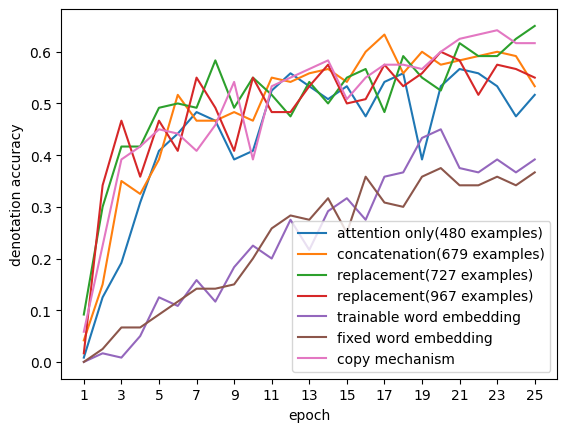

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('default')
epoch = np.arange(1,26)

fig,ax = plt.subplots()
ax.plot(epoch, attention_only, label = 'attention only(480 examples)')
ax.plot(epoch, concatenation,label = 'concatenation(679 examples)')
ax.plot(epoch, replace727,label = 'replacement(727 examples)')
ax.plot(epoch, replace967,label = 'replacement(967 examples)')
ax.plot(epoch, glove,label = 'trainable word embedding')
ax.plot(epoch, glove_nontrain,label = 'fixed word embedding')
ax.plot(epoch, copy_only,label = 'copy mechanism')
plt.xlabel('epoch')
plt.ylabel('denotation accuracy')
ax.set_xticks(np.arange(1,26,2))
#ax.set_title('result of mechanism')
ax.legend()
plt.show()

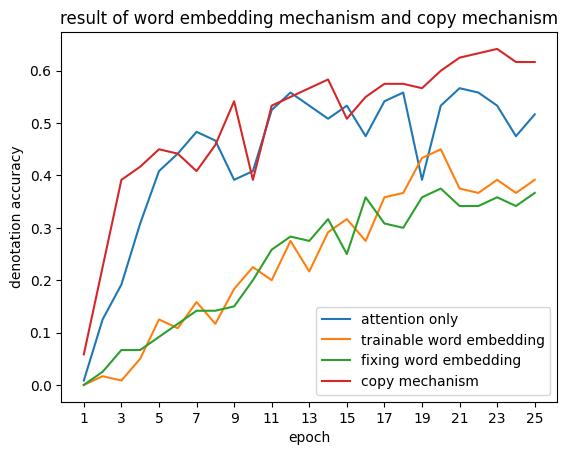

In [ ]:
epoch = np.arange(1,26)

fig,ax = plt.subplots()
ax.plot(epoch, attention_only, label = 'attention only')
ax.plot(epoch, glove,label = 'trainable word embedding')
ax.plot(epoch, glove_nontrain,label = 'fixing word embedding')
ax.plot(epoch, copy_only,label = 'copy mechanism')

plt.xlabel('epoch')
plt.ylabel('denotation accuracy')
ax.set_xticks(np.arange(1,26,2))
ax.set_title('result of word embedding mechanism and copy mechanism')
ax.legend()
plt.show()

In [ ]:
print(len(final_result1))

35


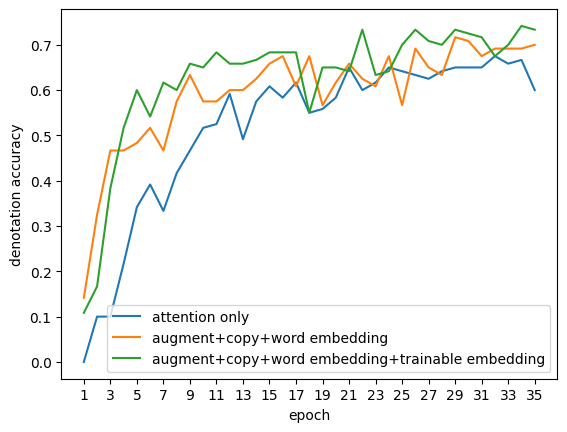

In [ ]:
epoch = np.arange(1,36)

fig,ax = plt.subplots()
ax.plot(epoch, attention_only1, label = 'attention only')
ax.plot(epoch, final_result,label = 'augment+copy+word embedding')
ax.plot(epoch, final_result1,label = 'augment+copy+word embedding+trainable embedding')


plt.xlabel('epoch')
plt.ylabel('denotation accuracy')
ax.set_xticks(np.arange(1,36,2))
#ax.set_title('result of hybrid mechanisms')
ax.legend()
plt.show()